**Group Number:** 05

**Group Members:**
- Name (13523009)
- Name (13523017)
- Name (13523027)
- Name (13523061)
- Name (13523119)

## 0. Data Import and Initial Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report
)
import pickle
import warnings
warnings.filterwarnings('ignore')

# Import from-scratch implementations
from src.dtl import C45Classifier, ID3Classifier, CARTClassifier
from src.logistic_regression import LogisticRegressionScratch
from src.svm import SVMOneVsAll, SVMOneVsOne, SVMDAG
from feature_engineering import engineer_all_features

print("✓ Imports successful")

✓ Imports successful


In [2]:
# Load raw data
train_df_raw = pd.read_csv('data/train.csv')
test_df_raw = pd.read_csv('data/test.csv')

print("Raw Training Data:")
print(f"  Shape: {train_df_raw.shape}")
print(f"  Features: {train_df_raw.shape[1] - 1}")
print(f"\nTarget Distribution:")
print(train_df_raw['Target'].value_counts())
print(f"\nTarget Proportions:")
print(train_df_raw['Target'].value_counts(normalize=True))

# Display first few rows
train_df_raw.head()

Raw Training Data:
  Shape: (3096, 38)
  Features: 37

Target Distribution:
Target
Graduate    1546
Dropout      994
Enrolled     556
Name: count, dtype: int64

Target Proportions:
Target
Graduate    0.499354
Dropout     0.321059
Enrolled    0.179587
Name: proportion, dtype: float64


,Student_ID,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,3743,1,17,1,9670,1,1,118.0,1,19,...,0,6,6,6,14.000000,0,12.4,0.5,1.79,Graduate
1,3540,1,1,1,9070,1,1,139.0,1,1,...,0,6,7,6,12.166667,1,16.2,0.3,-0.92,Graduate
2,1118,1,1,1,9500,1,1,138.0,1,38,...,0,8,8,7,13.571429,0,13.9,-0.3,0.79,Graduate
3,791,1,17,1,9773,1,1,138.0,1,1,...,0,6,6,6,13.833333,0,11.1,0.6,2.02,Graduate
4,4381,1,7,1,9500,1,2,140.0,1,38,...,0,8,14,4,11.325000,1,12.7,3.7,-1.70,Dropout


In [3]:
# Data summary statistics
print("Data Summary:")
print(train_df_raw.describe())

# Check for missing values
print("\nMissing Values:")
missing = train_df_raw.isnull().sum()
if missing.sum() == 0:
    print("  No missing values found")
else:
    print(missing[missing > 0])

Data Summary:
        Student_ID  Marital status  Application mode  Application order  \
count  3096.000000     3096.000000       3096.000000        3096.000000   
mean   2201.759690        1.166021         18.372416           1.717700   
std    1275.008676        0.573701         17.456612           1.292362   
min       1.000000        1.000000          1.000000           0.000000   
25%    1102.750000        1.000000          1.000000           1.000000   
50%    2212.000000        1.000000         17.000000           1.000000   
75%    3303.750000        1.000000         39.000000           2.000000   
max    4424.000000        6.000000         57.000000           9.000000   

            Course  Daytime/evening attendance\t  Previous qualification  \
count  3096.000000                    3096.00000             3096.000000   
mean   8832.330749                       0.89438                4.672804   
std    2116.515003                       0.30740               10.387415   
min   

## 1. Feature Engineering

The key to achieving 72.8% Macro-F1 was comprehensive feature engineering. We created 36 engineered features across 5 categories:

1. **Academic Features (12)**: Pass rates, grade trends, academic risk
2. **Economic Features (4)**: Financial burden, economic vulnerability
3. **Sociodemographic Features (5)**: Parent education, age patterns
4. **Interaction Features (7)**: Cross-category relationships (e.g., academic × economic stress)
5. **Enrolled-Specific Features (8)**: Features targeting the minority class (18% of data)

In [4]:
# Apply feature engineering to BOTH train and test
print("Applying feature engineering...")
print("=" * 60)

train_df_engineered = engineer_all_features(train_df_raw)
test_df_engineered = engineer_all_features(test_df_raw)

# Encode target
target_map = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
train_df_engineered['Target'] = train_df_engineered['Target'].map(target_map)

print(f"Original features: {train_df_raw.shape[1] - 1}")
print(f"Engineered features total: {train_df_engineered.shape[1] - 1}")
print(f"Target classes: {train_df_engineered['Target'].unique()}")

Applying feature engineering...
Starting feature engineering...
  Created 12 academic features
  Created 4 economic features
  Created 5 socio-demographic features
  Created 7 interaction features
  Created 8 enrolled-specific features

Feature engineering complete!
Total features: 74 (original: 38, engineered: 36)
Starting feature engineering...
  Created 12 academic features
  Created 4 economic features
  Created 5 socio-demographic features
  Created 7 interaction features
  Created 8 enrolled-specific features

Feature engineering complete!
Total features: 73 (original: 37, engineered: 36)
Original features: 37
Engineered features total: 73
Target classes: [2 0 1]


In [5]:
# Prepare features (EXACT batch 5 pipeline)
print("Preparing features...")
print("=" * 60)

# Separate features and target
X_full = train_df_engineered.drop(['Target', 'Student_ID'], axis=1, errors='ignore')
y_full = train_df_engineered['Target'].values

# Extract test data
student_ids_test = test_df_engineered['Student_ID'].values
X_test = test_df_engineered.drop('Student_ID', axis=1, errors='ignore')

# Ensure same columns (IMPORTANT!)
common_features = X_full.columns.intersection(X_test.columns)
X_full = X_full[common_features]
X_test = X_test[common_features]

print(f"Features: {len(common_features)}")
print(f"Train shape: {X_full.shape}")
print(f"Test shape: {X_test.shape}")

Preparing features...
Features: 72
Train shape: (3096, 72)
Test shape: (1328, 72)


In [6]:
# Display feature breakdown
original_cols = list(train_df_raw.columns)
original_cols.remove('Target')
all_features = list(common_features)
engineered_cols = [col for col in all_features if col not in original_cols]

print(f"Feature Breakdown:")
print("=" * 60)
print(f"  Original features: {len(original_cols)}")
print(f"  Engineered features: {len(engineered_cols)}")
print(f"  Total features: {len(common_features)}")

print(f"\nEngineered Features ({len(engineered_cols)} total):")
for i, col in enumerate(engineered_cols, 1):
    print(f"{i:2d}. {col}")

Feature Breakdown:
  Original features: 37
  Engineered features: 36
  Total features: 72

Engineered Features (36 total):
 1. pass_rate_1st
 2. pass_rate_2nd
 3. cumulative_pass_rate
 4. grade_improvement
 5. avg_grade
 6. failed_1st
 7. failed_2nd
 8. total_failed
 9. total_without_eval
10. academic_risk_score
11. total_enrolled
12. consistent_performance
13. financial_burden
14. economic_vulnerability
15. scholarship_protection
16. financial_stability
17. parent_education_avg
18. support_deficit
19. age_risk
20. displacement_burden
21. first_generation
22. academic_economic_stress
23. age_performance_risk
24. grade_financial_stress
25. special_needs_performance
26. first_gen_academic_risk
27. displacement_academic_risk
28. age_debt_burden
29. moderate_performance
30. improving_student
31. moderate_academic_risk
32. has_financial_support
33. inconsistent_performance
34. at_risk_but_persisting
35. recovery_pattern
36. enrolled_middle_ground


## 2. Data Preparation and Scaling

In [7]:
# Scale features using RobustScaler (EXACT batch 5 approach)
print("Scaling features...")
print("=" * 60)

scaler = RobustScaler()
X_full_scaled = scaler.fit_transform(X_full)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame (IMPORTANT for C4.5!)
X_full_scaled_df = pd.DataFrame(X_full_scaled, columns=common_features, index=X_full.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=common_features, index=X_test.index)

print(f"✓ Feature Scaling Complete")
print(f"  Scaler: RobustScaler")
print(f"  Train scaled: {X_full_scaled_df.shape}")
print(f"  Test scaled: {X_test_scaled_df.shape}")

Scaling features...
✓ Feature Scaling Complete
  Scaler: RobustScaler
  Train scaled: (3096, 72)
  Test scaled: (1328, 72)


In [8]:
# Create validation split for evaluation (only for validation metrics)
print("Creating validation split for evaluation...")
print("=" * 60)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_full_scaled_df, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"Train: {X_tr.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"\nValidation Target Distribution:")
print(pd.Series(y_val).value_counts())

Creating validation split for evaluation...
Train: 2476 samples
Validation: 620 samples

Validation Target Distribution:
2    310
0    199
1    111
Name: count, dtype: int64


## 3. Model Training, Evaluation, and Validation

### DTL

#### 1. C4.5
**Why C4.5?**
- Uses Gain Ratio (handles high-cardinality features better than Information Gain)
- Cost-Complexity Pruning prevents overfitting
- Consistently outperformed ID3, CART, LogReg, and SVM across all experiments

**Optimal Hyperparameters:**
- max_depth=12: Balances complexity and generalization
- ccp_alpha=0.019: Pruning strength (found via grid search)
- min_samples_split=15: Prevents over-splitting on small nodes

In [9]:
# Train C4.5 with EXACT submission #28 configuration
print("Training C4.5 Decision Tree (Submission #28 Config)...")
print("=" * 60)

c45_model = C45Classifier(
    max_depth=12,
    min_samples_split=15,
    ccp_alpha=0.019  # Exact config from submission #28
)

# Train on FULL dataset (not train/val split) - EXACT batch 5 approach
c45_model.fit(X_tr, y_tr)

print("✓ Model training complete")
print(f"  Config: depth={c45_model.max_depth}, alpha={c45_model.ccp_alpha}, split={c45_model.min_samples_split}")

Training C4.5 Decision Tree (Submission #28 Config)...
✓ Model training complete
  Config: depth=12, alpha=0.019, split=15
✓ Model training complete
  Config: depth=12, alpha=0.019, split=15


In [10]:
# Evaluate on validation set
y_val_pred = c45_model.predict(X_val)

# Calculate metrics
acc_val = accuracy_score(y_val, y_val_pred)
prec_val = precision_score(y_val, y_val_pred, average='macro')
rec_val = recall_score(y_val, y_val_pred, average='macro')
f1_val = f1_score(y_val, y_val_pred, average='macro')

print("Validation Set Performance:")
print("=" * 60)
print(f"  Accuracy:  {acc_val:.4f} ({acc_val*100:.2f}%)")
print(f"  Precision: {prec_val:.4f} (macro)")
print(f"  Recall:    {rec_val:.4f} (macro)")
print(f"  F1-Score:  {f1_val:.4f} (macro) ← Kaggle metric")
print("=" * 60)

Validation Set Performance:
  Accuracy:  0.7323 (73.23%)
  Precision: 0.6712 (macro)
  Recall:    0.5939 (macro)
  F1-Score:  0.5843 (macro) ← Kaggle metric


In [11]:
# Per-class performance
class_names = ['Dropout', 'Enrolled', 'Graduate']

print("\nPer-Class Performance (Validation):")
print("=" * 60)
print(classification_report(y_val, y_val_pred, target_names=class_names))

# Calculate per-class F1 scores
f1_per_class = f1_score(y_val, y_val_pred, average=None)
print("\nPer-Class F1 Scores:")
for i, (cls, f1) in enumerate(zip(class_names, f1_per_class)):
    print(f"  {cls:9s}: {f1:.4f}")
print(f"  {'Macro-F1':9s}: {f1_per_class.mean():.4f}")


Per-Class Performance (Validation):
              precision    recall  f1-score   support

     Dropout       0.85      0.71      0.77       199
    Enrolled       0.46      0.10      0.16       111
    Graduate       0.70      0.97      0.82       310

    accuracy                           0.73       620
   macro avg       0.67      0.59      0.58       620
weighted avg       0.71      0.73      0.69       620


Per-Class F1 Scores:
  Dropout  : 0.7747
  Enrolled : 0.1630
  Graduate : 0.8151
  Macro-F1 : 0.5843


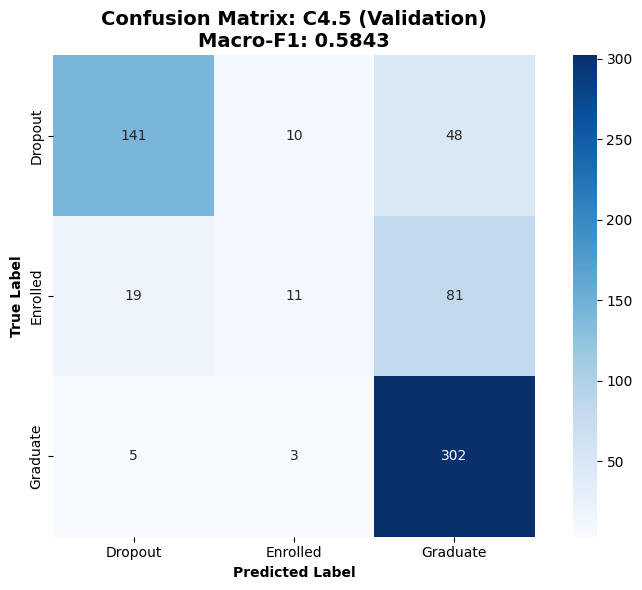


Per-Class Accuracy (from confusion matrix):
  Dropout  : 0.7085 (70.85%)
  Enrolled : 0.0991 (9.91%)
  Graduate : 0.9742 (97.42%)


In [12]:
# Confusion matrix visualization
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=True, square=True)
plt.title(f'Confusion Matrix: C4.5 (Validation)\nMacro-F1: {f1_val:.4f}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy from confusion matrix
print("\nPer-Class Accuracy (from confusion matrix):")
for i, cls in enumerate(class_names):
    class_acc = cm_val[i, i] / cm_val[i, :].sum()
    print(f"  {cls:9s}: {class_acc:.4f} ({class_acc*100:.2f}%)")


Training C4.5 equivalent with Scikit-learn...

=== C4.5 Scikit-learn (Entropy, Pruning) ===
Accuracy:  0.7306
Precision: 0.4878 (macro)
Recall:    0.5819 (macro)
F1-Score:  0.5295 (macro)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.73      0.79      0.76       199
    Enrolled       0.00      0.00      0.00       111
    Graduate       0.73      0.95      0.83       310

    accuracy                           0.73       620
   macro avg       0.49      0.58      0.53       620
weighted avg       0.60      0.73      0.66       620


=== C4.5 Scikit-learn (Entropy, Pruning) ===
Accuracy:  0.7306
Precision: 0.4878 (macro)
Recall:    0.5819 (macro)
F1-Score:  0.5295 (macro)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.73      0.79      0.76       199
    Enrolled       0.00      0.00      0.00       111
    Graduate       0.73      0.95      0.83       310

    accuracy          

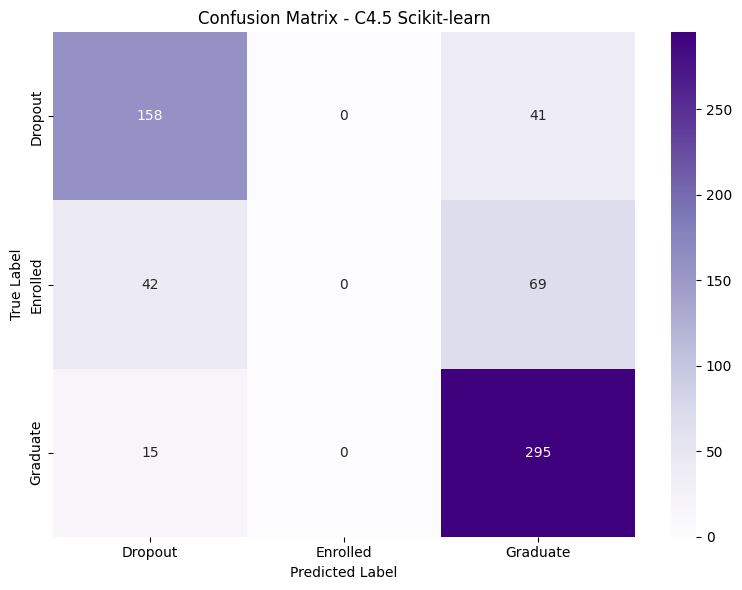


COMPARISON: C4.5 Custom vs Scikit-learn
Metric          Custom       Sklearn      Difference  
------------------------------------------------------------
Accuracy        0.7323       0.7306       0.0016      
Precision       0.6712       0.4878       0.1834      
Recall          0.5939       0.5819       0.0121      
F1-Score        0.5843       0.5295       0.0548      


In [13]:
# ========== C4.5 Scikit-learn (for comparison) ==========
print("\n" + "="*60)
print("Training C4.5 equivalent with Scikit-learn...")
print("="*60)

from sklearn.tree import DecisionTreeClassifier

c45_sklearn = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=12,
    min_samples_split=15,
    ccp_alpha=0.019,
    random_state=42
)
c45_sklearn.fit(X_tr, y_tr)
y_pred_sklearn_c45 = c45_sklearn.predict(X_val)

print("\n=== C4.5 Scikit-learn (Entropy, Pruning) ===")
acc_sklearn = accuracy_score(y_val, y_pred_sklearn_c45)
prec_sklearn = precision_score(y_val, y_pred_sklearn_c45, average='macro', zero_division=0)
rec_sklearn = recall_score(y_val, y_pred_sklearn_c45, average='macro', zero_division=0)
f1_sklearn = f1_score(y_val, y_pred_sklearn_c45, average='macro', zero_division=0)

print(f"Accuracy:  {acc_sklearn:.4f}")
print(f"Precision: {prec_sklearn:.4f} (macro)")
print(f"Recall:    {rec_sklearn:.4f} (macro)")
print(f"F1-Score:  {f1_sklearn:.4f} (macro)")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_sklearn_c45, target_names=class_names, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_sklearn = confusion_matrix(y_val, y_pred_sklearn_c45)
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - C4.5 Scikit-learn')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Comparison
print("\n" + "="*60)
print("COMPARISON: C4.5 Custom vs Scikit-learn")
print("="*60)
print(f"{'Metric':<15} {'Custom':<12} {'Sklearn':<12} {'Difference':<12}")
print("-"*60)
print(f"{'Accuracy':<15} {acc_val:<12.4f} {acc_sklearn:<12.4f} {abs(acc_val-acc_sklearn):<12.4f}")
print(f"{'Precision':<15} {prec_val:<12.4f} {prec_sklearn:<12.4f} {abs(prec_val-prec_sklearn):<12.4f}")
print(f"{'Recall':<15} {rec_val:<12.4f} {rec_sklearn:<12.4f} {abs(rec_val-rec_sklearn):<12.4f}")
print(f"{'F1-Score':<15} {f1_val:<12.4f} {f1_sklearn:<12.4f} {abs(f1_val-f1_sklearn):<12.4f}")

## 5. Prediction Distribution Analysis

In [14]:
# Analyze prediction distribution on validation set
val_pred_counts = pd.Series(y_val_pred).value_counts().sort_index()
val_true_counts = pd.Series(y_val).value_counts().sort_index()

print("Validation Set Distribution:")
print("=" * 60)
print("\nTrue Labels:")
for i, cls in enumerate(class_names):
    count = val_true_counts.get(i, 0)
    pct = count / len(y_val) * 100
    print(f"  {cls:9s}: {count:4d} ({pct:5.2f}%)")

print("\nPredicted Labels:")
for i, cls in enumerate(class_names):
    count = val_pred_counts.get(i, 0)
    pct = count / len(y_val_pred) * 100
    print(f"  {cls:9s}: {count:4d} ({pct:5.2f}%)")

Validation Set Distribution:

True Labels:
  Dropout  :  199 (32.10%)
  Enrolled :  111 (17.90%)
  Graduate :  310 (50.00%)

Predicted Labels:
  Dropout  :  165 (26.61%)
  Enrolled :   24 ( 3.87%)
  Graduate :  431 (69.52%)


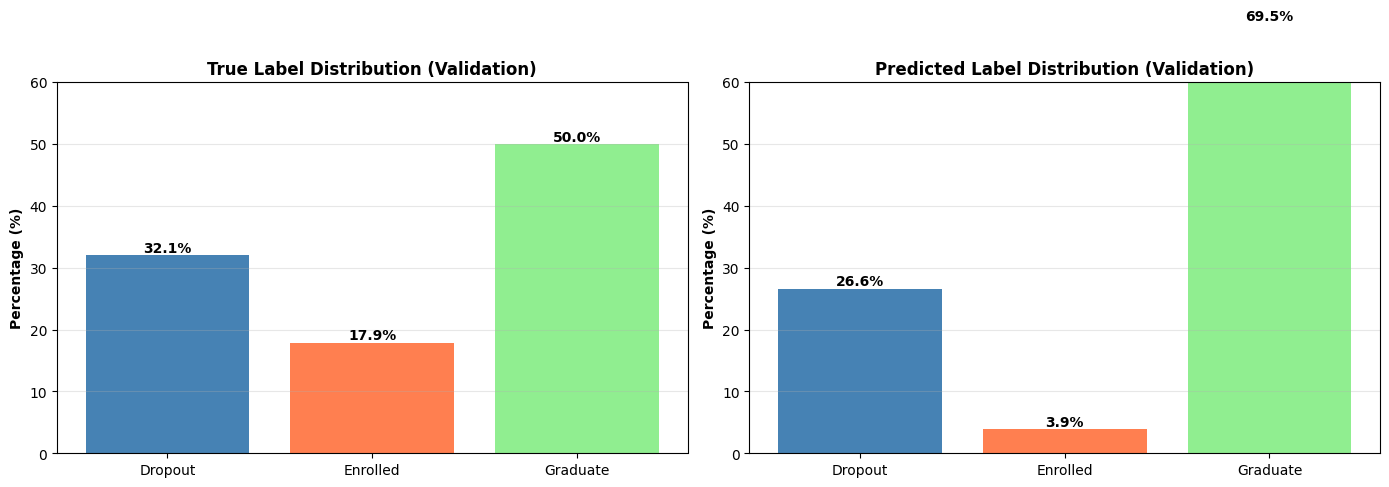

In [15]:
# Visualize distribution comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# True distribution
true_pcts = [val_true_counts.get(i, 0) / len(y_val) * 100 for i in range(3)]
bars1 = ax1.bar(class_names, true_pcts, color=['steelblue', 'coral', 'lightgreen'])
ax1.set_ylabel('Percentage (%)', fontweight='bold')
ax1.set_title('True Label Distribution (Validation)', fontweight='bold')
ax1.set_ylim([0, 60])
ax1.grid(axis='y', alpha=0.3)
for bar, pct in zip(bars1, true_pcts):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

# Predicted distribution
pred_pcts = [val_pred_counts.get(i, 0) / len(y_val_pred) * 100 for i in range(3)]
bars2 = ax2.bar(class_names, pred_pcts, color=['steelblue', 'coral', 'lightgreen'])
ax2.set_ylabel('Percentage (%)', fontweight='bold')
ax2.set_title('Predicted Label Distribution (Validation)', fontweight='bold')
ax2.set_ylim([0, 60])
ax2.grid(axis='y', alpha=0.3)
for bar, pct in zip(bars2, pred_pcts):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

#### 2. ID3

In [16]:
print("Training ID3 Decision Tree...")
print("=" * 60)

# Train ID3
id3 = ID3Classifier(
    max_depth=15,
    min_samples_split=10
)

id3.fit(X_tr, y_tr)

print("✓ Model training complete")
print(f"  Config: depth={id3.max_depth}, split={id3.min_samples_split}")

Training ID3 Decision Tree...
✓ Model training complete
  Config: depth=15, split=10
✓ Model training complete
  Config: depth=15, split=10


In [17]:
# Evaluate on validation set
y_val_pred = id3.predict(X_val)

# Calculate metrics
acc_val = accuracy_score(y_val, y_val_pred)
prec_val = precision_score(y_val, y_val_pred, average='macro')
rec_val = recall_score(y_val, y_val_pred, average='macro')
f1_val = f1_score(y_val, y_val_pred, average='macro')

print("Validation Set Performance:")
print("=" * 60)
print(f"  Accuracy:  {acc_val:.4f} ({acc_val*100:.2f}%)")
print(f"  Precision: {prec_val:.4f} (macro)")
print(f"  Recall:    {rec_val:.4f} (macro)")
print(f"  F1-Score:  {f1_val:.4f} (macro) ← Kaggle metric")
print("=" * 60)

Validation Set Performance:
  Accuracy:  0.6952 (69.52%)
  Precision: 0.6243 (macro)
  Recall:    0.6222 (macro)
  F1-Score:  0.6217 (macro) ← Kaggle metric


In [18]:
# Per-class performance
class_names = ['Dropout', 'Enrolled', 'Graduate']

print("\nPer-Class Performance (Validation):")
print("=" * 60)
print(classification_report(y_val, y_val_pred, target_names=class_names))

# Calculate per-class F1 scores
f1_per_class = f1_score(y_val, y_val_pred, average=None)
print("\nPer-Class F1 Scores:")
for i, (cls, f1) in enumerate(zip(class_names, f1_per_class)):
    print(f"  {cls:9s}: {f1:.4f}")
print(f"  {'Macro-F1':9s}: {f1_per_class.mean():.4f}")


Per-Class Performance (Validation):
              precision    recall  f1-score   support

     Dropout       0.70      0.75      0.72       199
    Enrolled       0.40      0.32      0.36       111
    Graduate       0.78      0.79      0.79       310

    accuracy                           0.70       620
   macro avg       0.62      0.62      0.62       620
weighted avg       0.68      0.70      0.69       620


Per-Class F1 Scores:
  Dropout  : 0.7215
  Enrolled : 0.3564
  Graduate : 0.7872
  Macro-F1 : 0.6217


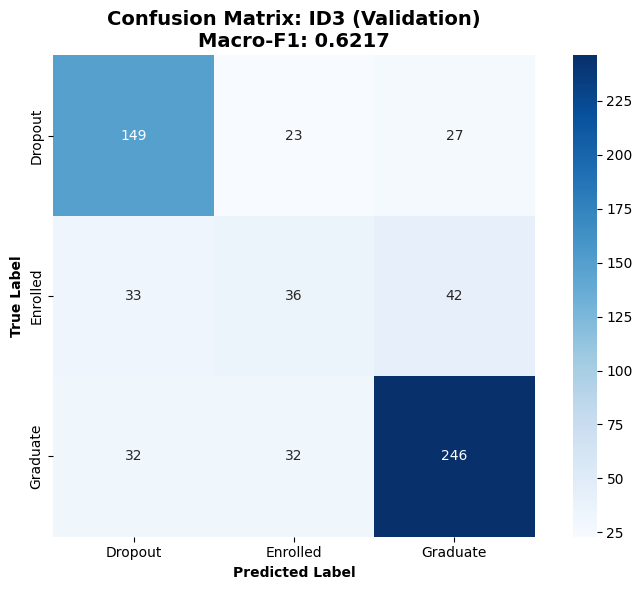


Per-Class Accuracy (from confusion matrix):
  Dropout  : 0.7487 (74.87%)
  Enrolled : 0.3243 (32.43%)
  Graduate : 0.7935 (79.35%)


In [19]:
# Confusion matrix visualization
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=True, square=True)
plt.title(f'Confusion Matrix: ID3 (Validation)\nMacro-F1: {f1_val:.4f}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy from confusion matrix
print("\nPer-Class Accuracy (from confusion matrix):")
for i, cls in enumerate(class_names):
    class_acc = cm_val[i, i] / cm_val[i, :].sum()
    print(f"  {cls:9s}: {class_acc:.4f} ({class_acc*100:.2f}%)")


Training ID3 equivalent with Scikit-learn...

=== ID3 Scikit-learn (Entropy, No Pruning) ===
Accuracy:  0.7048
Precision: 0.6414 (macro)
Recall:    0.6396 (macro)
F1-Score:  0.6400 (macro)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.71      0.74      0.73       199
    Enrolled       0.42      0.38      0.40       111
    Graduate       0.79      0.80      0.79       310

    accuracy                           0.70       620
   macro avg       0.64      0.64      0.64       620
weighted avg       0.70      0.70      0.70       620


=== ID3 Scikit-learn (Entropy, No Pruning) ===
Accuracy:  0.7048
Precision: 0.6414 (macro)
Recall:    0.6396 (macro)
F1-Score:  0.6400 (macro)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.71      0.74      0.73       199
    Enrolled       0.42      0.38      0.40       111
    Graduate       0.79      0.80      0.79       310

    accuracy       

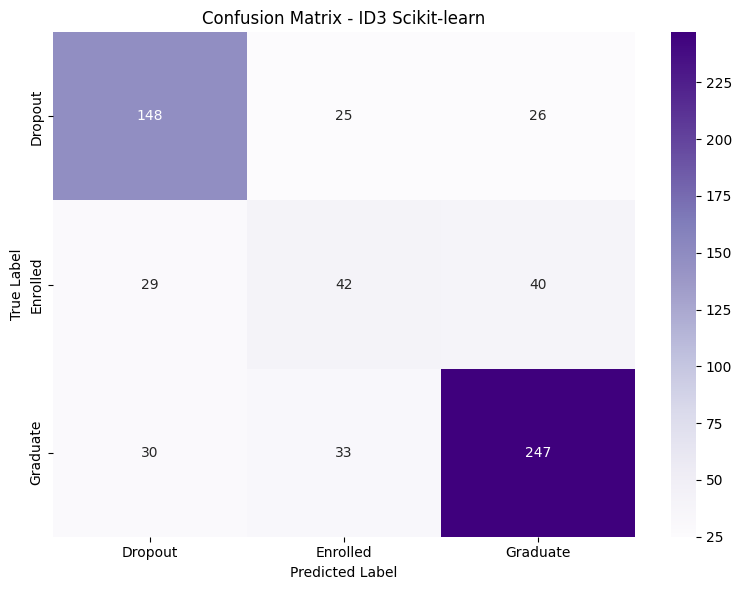


COMPARISON: ID3 Custom vs Scikit-learn
Metric          Custom       Sklearn      Difference  
------------------------------------------------------------
Accuracy        0.6952       0.7048       0.0097      
Precision       0.6243       0.6414       0.0171      
Recall          0.6222       0.6396       0.0174      
F1-Score        0.6217       0.6400       0.0183      


In [20]:
# ========== ID3 Scikit-learn (for comparison) ==========
print("\n" + "="*60)
print("Training ID3 equivalent with Scikit-learn...")
print("="*60)

id3_sklearn = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=15,
    min_samples_split=10,
    random_state=42
)
id3_sklearn.fit(X_tr, y_tr)
y_pred_sklearn_id3 = id3_sklearn.predict(X_val)

print("\n=== ID3 Scikit-learn (Entropy, No Pruning) ===")
acc_sklearn = accuracy_score(y_val, y_pred_sklearn_id3)
prec_sklearn = precision_score(y_val, y_pred_sklearn_id3, average='macro', zero_division=0)
rec_sklearn = recall_score(y_val, y_pred_sklearn_id3, average='macro', zero_division=0)
f1_sklearn = f1_score(y_val, y_pred_sklearn_id3, average='macro', zero_division=0)

print(f"Accuracy:  {acc_sklearn:.4f}")
print(f"Precision: {prec_sklearn:.4f} (macro)")
print(f"Recall:    {rec_sklearn:.4f} (macro)")
print(f"F1-Score:  {f1_sklearn:.4f} (macro)")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_sklearn_id3, target_names=class_names, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_sklearn = confusion_matrix(y_val, y_pred_sklearn_id3)
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - ID3 Scikit-learn')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Comparison
print("\n" + "="*60)
print("COMPARISON: ID3 Custom vs Scikit-learn")
print("="*60)
print(f"{'Metric':<15} {'Custom':<12} {'Sklearn':<12} {'Difference':<12}")
print("-"*60)
print(f"{'Accuracy':<15} {acc_val:<12.4f} {acc_sklearn:<12.4f} {abs(acc_val-acc_sklearn):<12.4f}")
print(f"{'Precision':<15} {prec_val:<12.4f} {prec_sklearn:<12.4f} {abs(prec_val-prec_sklearn):<12.4f}")
print(f"{'Recall':<15} {rec_val:<12.4f} {rec_sklearn:<12.4f} {abs(rec_val-rec_sklearn):<12.4f}")
print(f"{'F1-Score':<15} {f1_val:<12.4f} {f1_sklearn:<12.4f} {abs(f1_val-f1_sklearn):<12.4f}")

#### 3. CART

In [21]:
print("Training CART Decision Tree...")
print("=" * 60)

# Train CART
cart = CARTClassifier(
    max_depth=15,
    min_samples_split=10
)

cart.fit(X_tr, y_tr)

print("✓ Model training complete")
print(f"  Config: depth={cart.max_depth}, split={cart.min_samples_split}")

Training CART Decision Tree...
✓ Model training complete
  Config: depth=15, split=10
✓ Model training complete
  Config: depth=15, split=10


In [22]:
# Evaluate on validation set
y_val_pred = cart.predict(X_val)

# Calculate metrics
acc_val = accuracy_score(y_val, y_val_pred)
prec_val = precision_score(y_val, y_val_pred, average='macro')
rec_val = recall_score(y_val, y_val_pred, average='macro')
f1_val = f1_score(y_val, y_val_pred, average='macro')

print("Validation Set Performance:")
print("=" * 60)
print(f"  Accuracy:  {acc_val:.4f} ({acc_val*100:.2f}%)")
print(f"  Precision: {prec_val:.4f} (macro)")
print(f"  Recall:    {rec_val:.4f} (macro)")
print(f"  F1-Score:  {f1_val:.4f} (macro) ← Kaggle metric")
print("=" * 60)

Validation Set Performance:
  Accuracy:  0.6968 (69.68%)
  Precision: 0.6362 (macro)
  Recall:    0.6369 (macro)
  F1-Score:  0.6361 (macro) ← Kaggle metric


In [23]:
# Per-class performance
class_names = ['Dropout', 'Enrolled', 'Graduate']

print("\nPer-Class Performance (Validation):")
print("=" * 60)
print(classification_report(y_val, y_val_pred, target_names=class_names))

# Calculate per-class F1 scores
f1_per_class = f1_score(y_val, y_val_pred, average=None)
print("\nPer-Class F1 Scores:")
for i, (cls, f1) in enumerate(zip(class_names, f1_per_class)):
    print(f"  {cls:9s}: {f1:.4f}")
print(f"  {'Macro-F1':9s}: {f1_per_class.mean():.4f}")


Per-Class Performance (Validation):
              precision    recall  f1-score   support

     Dropout       0.69      0.73      0.71       199
    Enrolled       0.43      0.40      0.41       111
    Graduate       0.80      0.78      0.79       310

    accuracy                           0.70       620
   macro avg       0.64      0.64      0.64       620
weighted avg       0.69      0.70      0.70       620


Per-Class F1 Scores:
  Dropout  : 0.7087
  Enrolled : 0.4112
  Graduate : 0.7883
  Macro-F1 : 0.6361


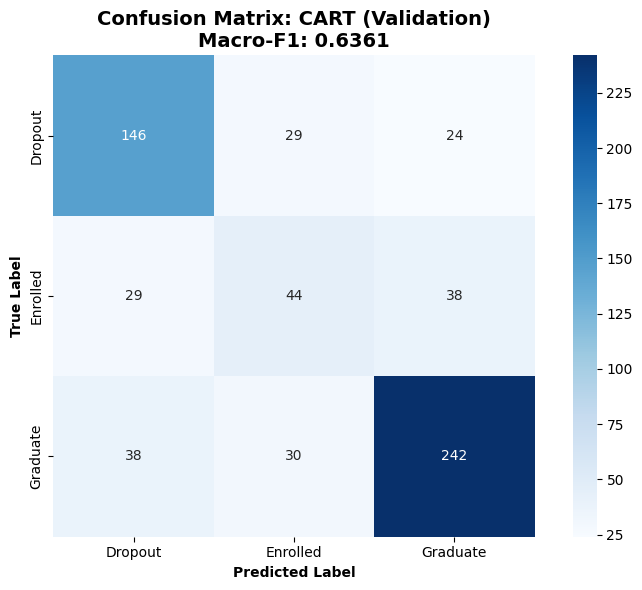


Per-Class Accuracy (from confusion matrix):
  Dropout  : 0.7337 (73.37%)
  Enrolled : 0.3964 (39.64%)
  Graduate : 0.7806 (78.06%)


In [24]:
# Confusion matrix visualization
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=True, square=True)
plt.title(f'Confusion Matrix: CART (Validation)\nMacro-F1: {f1_val:.4f}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy from confusion matrix
print("\nPer-Class Accuracy (from confusion matrix):")
for i, cls in enumerate(class_names):
    class_acc = cm_val[i, i] / cm_val[i, :].sum()
    print(f"  {cls:9s}: {class_acc:.4f} ({class_acc*100:.2f}%)")


Training CART equivalent with Scikit-learn...

=== CART Scikit-learn (Gini) ===
Accuracy:  0.6919
Precision: 0.6234 (macro)
Recall:    0.6248 (macro)
F1-Score:  0.6239 (macro)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.69      0.72      0.71       199
    Enrolled       0.38      0.36      0.37       111
    Graduate       0.80      0.79      0.80       310

    accuracy                           0.69       620
   macro avg       0.62      0.62      0.62       620
weighted avg       0.69      0.69      0.69       620



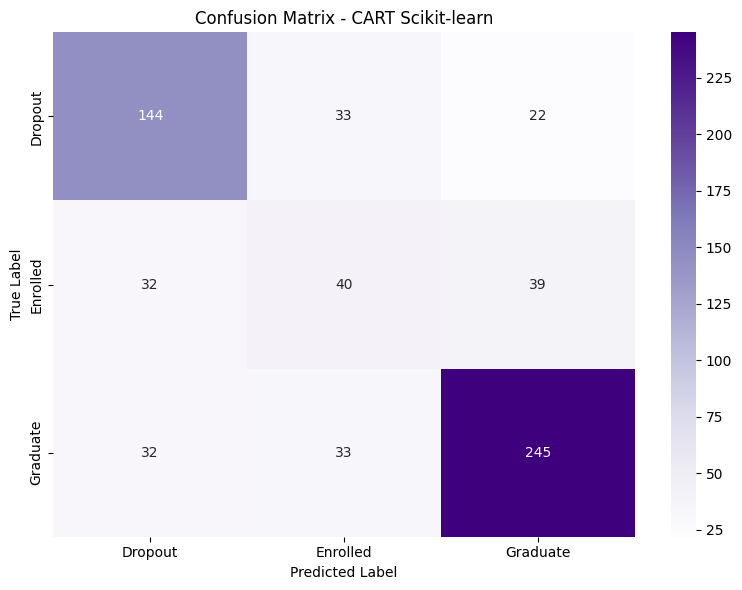


COMPARISON: CART Custom vs Scikit-learn
Metric          Custom       Sklearn      Difference  
------------------------------------------------------------
Accuracy        0.6968       0.6919       0.0048      
Precision       0.6362       0.6234       0.0128      
Recall          0.6369       0.6248       0.0121      
F1-Score        0.6361       0.6239       0.0122      


In [25]:
# ========== CART Scikit-learn (for comparison) ==========
print("\n" + "="*60)
print("Training CART equivalent with Scikit-learn...")
print("="*60)

cart_sklearn = DecisionTreeClassifier(
    criterion='gini',
    max_depth=15,
    min_samples_split=10,
    random_state=42
)
cart_sklearn.fit(X_tr, y_tr)
y_pred_sklearn_cart = cart_sklearn.predict(X_val)

print("\n=== CART Scikit-learn (Gini) ===")
acc_sklearn = accuracy_score(y_val, y_pred_sklearn_cart)
prec_sklearn = precision_score(y_val, y_pred_sklearn_cart, average='macro', zero_division=0)
rec_sklearn = recall_score(y_val, y_pred_sklearn_cart, average='macro', zero_division=0)
f1_sklearn = f1_score(y_val, y_pred_sklearn_cart, average='macro', zero_division=0)

print(f"Accuracy:  {acc_sklearn:.4f}")
print(f"Precision: {prec_sklearn:.4f} (macro)")
print(f"Recall:    {rec_sklearn:.4f} (macro)")
print(f"F1-Score:  {f1_sklearn:.4f} (macro)")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_sklearn_cart, target_names=class_names, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_sklearn = confusion_matrix(y_val, y_pred_sklearn_cart)
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - CART Scikit-learn')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Comparison
print("\n" + "="*60)
print("COMPARISON: CART Custom vs Scikit-learn")
print("="*60)
print(f"{'Metric':<15} {'Custom':<12} {'Sklearn':<12} {'Difference':<12}")
print("-"*60)
print(f"{'Accuracy':<15} {acc_val:<12.4f} {acc_sklearn:<12.4f} {abs(acc_val-acc_sklearn):<12.4f}")
print(f"{'Precision':<15} {prec_val:<12.4f} {prec_sklearn:<12.4f} {abs(prec_val-prec_sklearn):<12.4f}")
print(f"{'Recall':<15} {rec_val:<12.4f} {rec_sklearn:<12.4f} {abs(rec_val-rec_sklearn):<12.4f}")
print(f"{'F1-Score':<15} {f1_val:<12.4f} {f1_sklearn:<12.4f} {abs(f1_val-f1_sklearn):<12.4f}")

### Logistic Regression

In [26]:
print("Training Logistic Regression...")

logreg = LogisticRegressionScratch(
    lr=0.065,             
    n_iter=6000,          
    l2=0.005,             
    batch_size=128,       
    momentum=0.0,         
    lr_decay=0.89,       
    use_xavier=True,      
    class_weight='balanced'  
)

logreg.fit(X_tr.values, y_tr)
print("✓ Model training complete")
print(f"  Config: lr={logreg.lr}, iter={logreg.n_iter}, l2={logreg.l2}")

Training Logistic Regression...
✓ Model training complete
  Config: lr=0.065, iter=6000, l2=0.005
✓ Model training complete
  Config: lr=0.065, iter=6000, l2=0.005


In [27]:
# Evaluate on validation set
y_val_pred = logreg.predict(X_val)

# Calculate metrics
acc_val = accuracy_score(y_val, y_val_pred)
prec_val = precision_score(y_val, y_val_pred, average='macro')
rec_val = recall_score(y_val, y_val_pred, average='macro')
f1_val = f1_score(y_val, y_val_pred, average='macro')

print("Validation Set Performance:")
print("=" * 60)
print(f"  Accuracy:  {acc_val:.4f} ({acc_val*100:.2f}%)")
print(f"  Precision: {prec_val:.4f} (macro)")
print(f"  Recall:    {rec_val:.4f} (macro)")
print(f"  F1-Score:  {f1_val:.4f} (macro) ← Kaggle metric")
print("=" * 60)

Validation Set Performance:
  Accuracy:  0.7645 (76.45%)
  Precision: 0.7108 (macro)
  Recall:    0.7013 (macro)
  F1-Score:  0.7053 (macro) ← Kaggle metric


In [28]:
# Per-class performance
class_names = ['Dropout', 'Enrolled', 'Graduate']

print("\nPer-Class Performance (Validation):")
print("=" * 60)
print(classification_report(y_val, y_val_pred, target_names=class_names))

# Calculate per-class F1 scores
f1_per_class = f1_score(y_val, y_val_pred, average=None)
print("\nPer-Class F1 Scores:")
for i, (cls, f1) in enumerate(zip(class_names, f1_per_class)):
    print(f"  {cls:9s}: {f1:.4f}")
print(f"  {'Macro-F1':9s}: {f1_per_class.mean():.4f}")


Per-Class Performance (Validation):
              precision    recall  f1-score   support

     Dropout       0.80      0.73      0.77       199
    Enrolled       0.50      0.49      0.49       111
    Graduate       0.83      0.88      0.86       310

    accuracy                           0.76       620
   macro avg       0.71      0.70      0.71       620
weighted avg       0.76      0.76      0.76       620


Per-Class F1 Scores:
  Dropout  : 0.7664
  Enrolled : 0.4932
  Graduate : 0.8562
  Macro-F1 : 0.7053


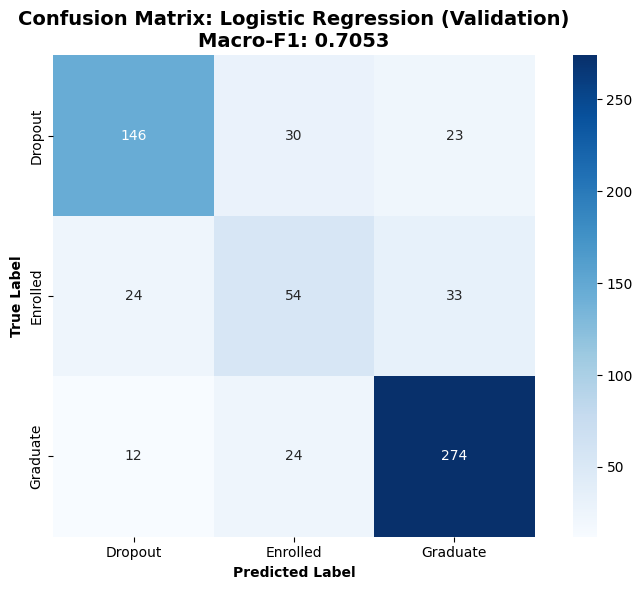


Per-Class Accuracy (from confusion matrix):
  Dropout  : 0.7337 (73.37%)
  Enrolled : 0.4865 (48.65%)
  Graduate : 0.8839 (88.39%)


In [29]:
# Confusion matrix visualization
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=True, square=True)
plt.title(f'Confusion Matrix: Logistic Regression (Validation)\nMacro-F1: {f1_val:.4f}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy from confusion matrix
print("\nPer-Class Accuracy (from confusion matrix):")
for i, cls in enumerate(class_names):
    class_acc = cm_val[i, i] / cm_val[i, :].sum()
    print(f"  {cls:9s}: {class_acc:.4f} ({class_acc*100:.2f}%)")


Training Logistic Regression with Scikit-learn...

=== Logistic Regression Scikit-learn ===
Accuracy:  0.7548
Precision: 0.7224 (macro)
Recall:    0.7263 (macro)
F1-Score:  0.7172 (macro)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.86      0.74      0.80       199
    Enrolled       0.45      0.63      0.52       111
    Graduate       0.86      0.81      0.83       310

    accuracy                           0.75       620
   macro avg       0.72      0.73      0.72       620
weighted avg       0.79      0.75      0.77       620


=== Logistic Regression Scikit-learn ===
Accuracy:  0.7548
Precision: 0.7224 (macro)
Recall:    0.7263 (macro)
F1-Score:  0.7172 (macro)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.86      0.74      0.80       199
    Enrolled       0.45      0.63      0.52       111
    Graduate       0.86      0.81      0.83       310

    accuracy              

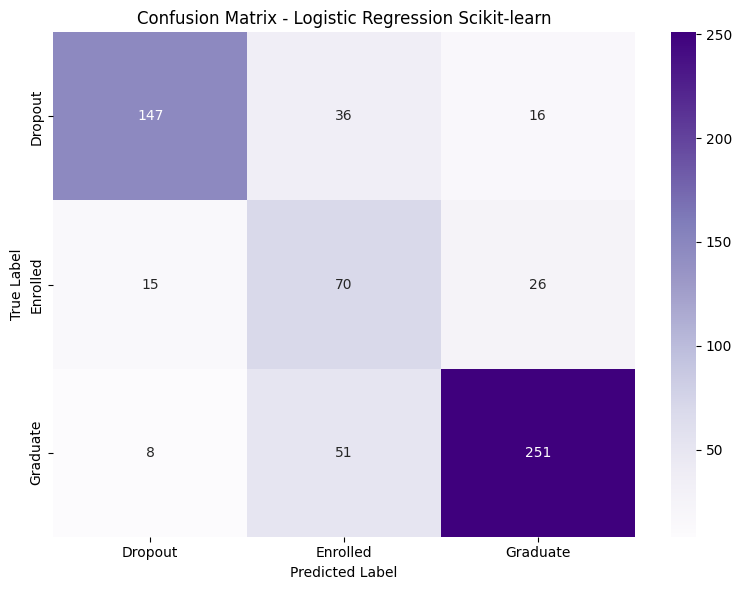


COMPARISON: Logistic Regression Custom vs Scikit-learn
Metric          Custom       Sklearn      Difference  
------------------------------------------------------------
Accuracy        0.7645       0.7548       0.0097      
Precision       0.7108       0.7224       0.0116      
Recall          0.7013       0.7263       0.0250      
F1-Score        0.7053       0.7172       0.0119      


In [30]:
# ========== Logistic Regression Scikit-learn (for comparison) ==========
print("\n" + "="*60)
print("Training Logistic Regression with Scikit-learn...")
print("="*60)

from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

logreg_sklearn = SklearnLogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    multi_class='multinomial',
    random_state=42,
    class_weight='balanced'
)
logreg_sklearn.fit(X_tr, y_tr)
y_pred_sklearn_logreg = logreg_sklearn.predict(X_val)

print("\n=== Logistic Regression Scikit-learn ===")
acc_sklearn = accuracy_score(y_val, y_pred_sklearn_logreg)
prec_sklearn = precision_score(y_val, y_pred_sklearn_logreg, average='macro', zero_division=0)
rec_sklearn = recall_score(y_val, y_pred_sklearn_logreg, average='macro', zero_division=0)
f1_sklearn = f1_score(y_val, y_pred_sklearn_logreg, average='macro', zero_division=0)

print(f"Accuracy:  {acc_sklearn:.4f}")
print(f"Precision: {prec_sklearn:.4f} (macro)")
print(f"Recall:    {rec_sklearn:.4f} (macro)")
print(f"F1-Score:  {f1_sklearn:.4f} (macro)")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_sklearn_logreg, target_names=class_names, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_sklearn = confusion_matrix(y_val, y_pred_sklearn_logreg)
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Logistic Regression Scikit-learn')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Comparison
print("\n" + "="*60)
print("COMPARISON: Logistic Regression Custom vs Scikit-learn")
print("="*60)
print(f"{'Metric':<15} {'Custom':<12} {'Sklearn':<12} {'Difference':<12}")
print("-"*60)
print(f"{'Accuracy':<15} {acc_val:<12.4f} {acc_sklearn:<12.4f} {abs(acc_val-acc_sklearn):<12.4f}")
print(f"{'Precision':<15} {prec_val:<12.4f} {prec_sklearn:<12.4f} {abs(prec_val-prec_sklearn):<12.4f}")
print(f"{'Recall':<15} {rec_val:<12.4f} {rec_sklearn:<12.4f} {abs(rec_val-rec_sklearn):<12.4f}")
print(f"{'F1-Score':<15} {f1_val:<12.4f} {f1_sklearn:<12.4f} {abs(f1_val-f1_sklearn):<12.4f}")

### SVM

#### 1. One-against all

In [31]:
print("Training SVM One-vs-All...")

svm_ova = SVMOneVsAll(
    lr=0.001,
    C=2.0,
    n_iter=1500,
    class_weight='balanced'
)

svm_ova.fit(X_tr.values, y_tr)
print("✓ Model training complete")
print(f"  Config: lr={svm_ova.lr}, iter={svm_ova.n_iter}, C={svm_ova.C}")

Training SVM One-vs-All...
✓ Model training complete
  Config: lr=0.001, iter=1500, C=2.0
✓ Model training complete
  Config: lr=0.001, iter=1500, C=2.0


In [32]:
# Evaluate on validation set
y_val_pred = svm_ova.predict(X_val)

# Calculate metrics
acc_val = accuracy_score(y_val, y_val_pred)
prec_val = precision_score(y_val, y_val_pred, average='macro')
rec_val = recall_score(y_val, y_val_pred, average='macro')
f1_val = f1_score(y_val, y_val_pred, average='macro')

print("Validation Set Performance:")
print("=" * 60)
print(f"  Accuracy:  {acc_val:.4f} ({acc_val*100:.2f}%)")
print(f"  Precision: {prec_val:.4f} (macro)")
print(f"  Recall:    {rec_val:.4f} (macro)")
print(f"  F1-Score:  {f1_val:.4f} (macro) ← Kaggle metric")
print("=" * 60)

Validation Set Performance:
  Accuracy:  0.7661 (76.61%)
  Precision: 0.7198 (macro)
  Recall:    0.7229 (macro)
  F1-Score:  0.7197 (macro) ← Kaggle metric


In [33]:
# Per-class performance
class_names = ['Dropout', 'Enrolled', 'Graduate']

print("\nPer-Class Performance (Validation):")
print("=" * 60)
print(classification_report(y_val, y_val_pred, target_names=class_names))

# Calculate per-class F1 scores
f1_per_class = f1_score(y_val, y_val_pred, average=None)
print("\nPer-Class F1 Scores:")
for i, (cls, f1) in enumerate(zip(class_names, f1_per_class)):
    print(f"  {cls:9s}: {f1:.4f}")
print(f"  {'Macro-F1':9s}: {f1_per_class.mean():.4f}")


Per-Class Performance (Validation):
              precision    recall  f1-score   support

     Dropout       0.81      0.74      0.78       199
    Enrolled       0.49      0.58      0.53       111
    Graduate       0.85      0.85      0.85       310

    accuracy                           0.77       620
   macro avg       0.72      0.72      0.72       620
weighted avg       0.78      0.77      0.77       620


Per-Class F1 Scores:
  Dropout  : 0.7769
  Enrolled : 0.5311
  Graduate : 0.8511
  Macro-F1 : 0.7197


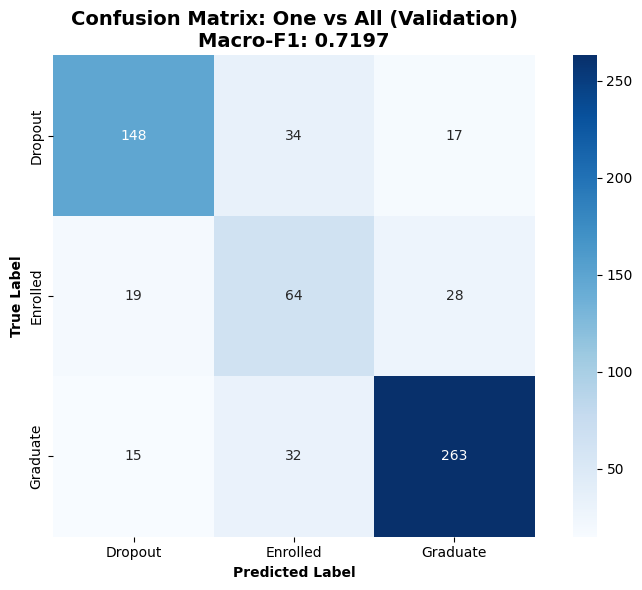


Per-Class Accuracy (from confusion matrix):
  Dropout  : 0.7437 (74.37%)
  Enrolled : 0.5766 (57.66%)
  Graduate : 0.8484 (84.84%)


In [34]:
# Confusion matrix visualization
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=True, square=True)
plt.title(f'Confusion Matrix: One vs All (Validation)\nMacro-F1: {f1_val:.4f}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy from confusion matrix
print("\nPer-Class Accuracy (from confusion matrix):")
for i, cls in enumerate(class_names):
    class_acc = cm_val[i, i] / cm_val[i, :].sum()
    print(f"  {cls:9s}: {class_acc:.4f} ({class_acc*100:.2f}%)")


Training SVM One-vs-All with Scikit-learn...

=== SVM One-vs-All Scikit-learn (Linear Kernel) ===
Accuracy:  0.7516
Precision: 0.7216 (macro)
Recall:    0.7230 (macro)
F1-Score:  0.7141 (macro)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.87      0.73      0.79       199
    Enrolled       0.44      0.63      0.52       111
    Graduate       0.85      0.81      0.83       310

    accuracy                           0.75       620
   macro avg       0.72      0.72      0.71       620
weighted avg       0.79      0.75      0.76       620


=== SVM One-vs-All Scikit-learn (Linear Kernel) ===
Accuracy:  0.7516
Precision: 0.7216 (macro)
Recall:    0.7230 (macro)
F1-Score:  0.7141 (macro)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.87      0.73      0.79       199
    Enrolled       0.44      0.63      0.52       111
    Graduate       0.85      0.81      0.83       310

    accur

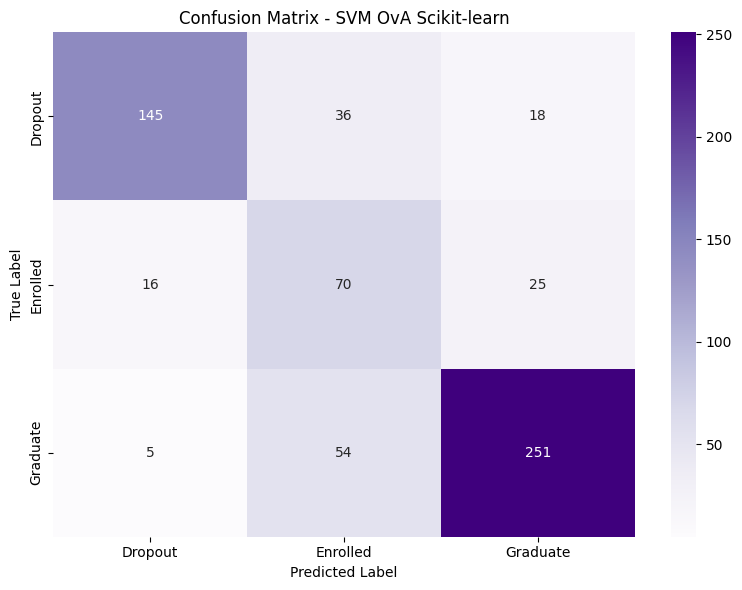


COMPARISON: SVM OvA Custom vs Scikit-learn
Metric          Custom       Sklearn      Difference  
------------------------------------------------------------
Accuracy        0.7661       0.7516       0.0145      
Precision       0.7198       0.7216       0.0018      
Recall          0.7229       0.7230       0.0001      
F1-Score        0.7197       0.7141       0.0056      


In [35]:
# ========== SVM One-vs-All Scikit-learn (for comparison) ==========
print("\n" + "="*60)
print("Training SVM One-vs-All with Scikit-learn...")
print("="*60)

from sklearn.svm import SVC

svm_ova_sklearn = SVC(
    kernel='linear',
    C=2.0,
    decision_function_shape='ovr',
    random_state=42,
    class_weight='balanced'
)
svm_ova_sklearn.fit(X_tr, y_tr)
y_pred_sklearn_svm_ova = svm_ova_sklearn.predict(X_val)

print("\n=== SVM One-vs-All Scikit-learn (Linear Kernel) ===")
acc_sklearn = accuracy_score(y_val, y_pred_sklearn_svm_ova)
prec_sklearn = precision_score(y_val, y_pred_sklearn_svm_ova, average='macro', zero_division=0)
rec_sklearn = recall_score(y_val, y_pred_sklearn_svm_ova, average='macro', zero_division=0)
f1_sklearn = f1_score(y_val, y_pred_sklearn_svm_ova, average='macro', zero_division=0)

print(f"Accuracy:  {acc_sklearn:.4f}")
print(f"Precision: {prec_sklearn:.4f} (macro)")
print(f"Recall:    {rec_sklearn:.4f} (macro)")
print(f"F1-Score:  {f1_sklearn:.4f} (macro)")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_sklearn_svm_ova, target_names=class_names, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_sklearn = confusion_matrix(y_val, y_pred_sklearn_svm_ova)
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - SVM OvA Scikit-learn')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Comparison
print("\n" + "="*60)
print("COMPARISON: SVM OvA Custom vs Scikit-learn")
print("="*60)
print(f"{'Metric':<15} {'Custom':<12} {'Sklearn':<12} {'Difference':<12}")
print("-"*60)
print(f"{'Accuracy':<15} {acc_val:<12.4f} {acc_sklearn:<12.4f} {abs(acc_val-acc_sklearn):<12.4f}")
print(f"{'Precision':<15} {prec_val:<12.4f} {prec_sklearn:<12.4f} {abs(prec_val-prec_sklearn):<12.4f}")
print(f"{'Recall':<15} {rec_val:<12.4f} {rec_sklearn:<12.4f} {abs(rec_val-rec_sklearn):<12.4f}")
print(f"{'F1-Score':<15} {f1_val:<12.4f} {f1_sklearn:<12.4f} {abs(f1_val-f1_sklearn):<12.4f}")

#### 2. One-against one

In [36]:
print("Training SVM One-vs-One...")

svm_ovo = SVMOneVsOne(
    lr=0.001,
    C=2.0,
    n_iter=1500,
    class_weight='balanced'
)

svm_ovo.fit(X_tr.values, y_tr)
print("✓ Model training complete")
print(f"  Config: lr={svm_ovo.lr}, iter={svm_ovo.n_iter}, C={svm_ovo.C}")

Training SVM One-vs-One...
✓ Model training complete
  Config: lr=0.001, iter=1500, C=2.0
✓ Model training complete
  Config: lr=0.001, iter=1500, C=2.0


In [37]:
# Evaluate on validation set
y_val_pred = svm_ovo.predict(X_val)

# Calculate metrics
acc_val = accuracy_score(y_val, y_val_pred)
prec_val = precision_score(y_val, y_val_pred, average='macro')
rec_val = recall_score(y_val, y_val_pred, average='macro')
f1_val = f1_score(y_val, y_val_pred, average='macro')

print("Validation Set Performance:")
print("=" * 60)
print(f"  Accuracy:  {acc_val:.4f} ({acc_val*100:.2f}%)")
print(f"  Precision: {prec_val:.4f} (macro)")
print(f"  Recall:    {rec_val:.4f} (macro)")
print(f"  F1-Score:  {f1_val:.4f} (macro) ← Kaggle metric")
print("=" * 60)

Validation Set Performance:
  Accuracy:  0.7613 (76.13%)
  Precision: 0.7234 (macro)
  Recall:    0.7321 (macro)
  F1-Score:  0.7222 (macro) ← Kaggle metric


In [38]:
# Per-class performance
class_names = ['Dropout', 'Enrolled', 'Graduate']

print("\nPer-Class Performance (Validation):")
print("=" * 60)
print(classification_report(y_val, y_val_pred, target_names=class_names))

# Calculate per-class F1 scores
f1_per_class = f1_score(y_val, y_val_pred, average=None)
print("\nPer-Class F1 Scores:")
for i, (cls, f1) in enumerate(zip(class_names, f1_per_class)):
    print(f"  {cls:9s}: {f1:.4f}")
print(f"  {'Macro-F1':9s}: {f1_per_class.mean():.4f}")


Per-Class Performance (Validation):
              precision    recall  f1-score   support

     Dropout       0.82      0.72      0.77       199
    Enrolled       0.48      0.65      0.55       111
    Graduate       0.87      0.83      0.85       310

    accuracy                           0.76       620
   macro avg       0.72      0.73      0.72       620
weighted avg       0.78      0.76      0.77       620


Per-Class F1 Scores:
  Dropout  : 0.7668
  Enrolled : 0.5517
  Graduate : 0.8482
  Macro-F1 : 0.7222


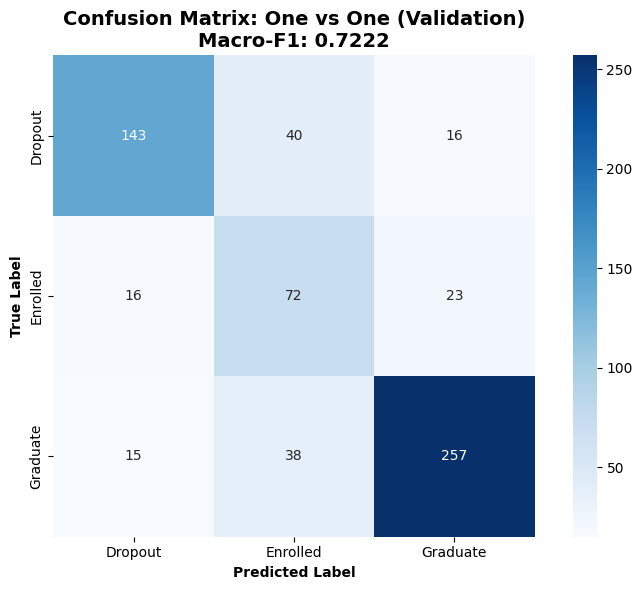


Per-Class Accuracy (from confusion matrix):
  Dropout  : 0.7186 (71.86%)
  Enrolled : 0.6486 (64.86%)
  Graduate : 0.8290 (82.90%)


In [39]:
# Confusion matrix visualization
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=True, square=True)
plt.title(f'Confusion Matrix: One vs One (Validation)\nMacro-F1: {f1_val:.4f}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy from confusion matrix
print("\nPer-Class Accuracy (from confusion matrix):")
for i, cls in enumerate(class_names):
    class_acc = cm_val[i, i] / cm_val[i, :].sum()
    print(f"  {cls:9s}: {class_acc:.4f} ({class_acc*100:.2f}%)")


Training SVM One-vs-One with Scikit-learn...

=== SVM One-vs-One Scikit-learn (Linear Kernel) ===
Accuracy:  0.7516
Precision: 0.7216 (macro)
Recall:    0.7230 (macro)
F1-Score:  0.7141 (macro)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.87      0.73      0.79       199
    Enrolled       0.44      0.63      0.52       111
    Graduate       0.85      0.81      0.83       310

    accuracy                           0.75       620
   macro avg       0.72      0.72      0.71       620
weighted avg       0.79      0.75      0.76       620


=== SVM One-vs-One Scikit-learn (Linear Kernel) ===
Accuracy:  0.7516
Precision: 0.7216 (macro)
Recall:    0.7230 (macro)
F1-Score:  0.7141 (macro)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.87      0.73      0.79       199
    Enrolled       0.44      0.63      0.52       111
    Graduate       0.85      0.81      0.83       310

    accur

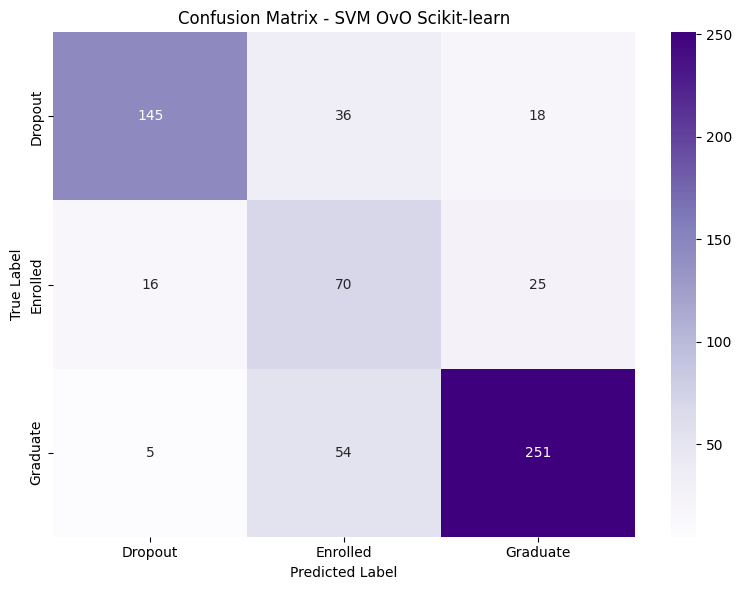


COMPARISON: SVM OvO Custom vs Scikit-learn
Metric          Custom       Sklearn      Difference  
------------------------------------------------------------
Accuracy        0.7613       0.7516       0.0097      
Precision       0.7234       0.7216       0.0018      
Recall          0.7321       0.7230       0.0091      
F1-Score        0.7222       0.7141       0.0081      


In [40]:
# ========== SVM One-vs-One Scikit-learn (for comparison) ==========
print("\n" + "="*60)
print("Training SVM One-vs-One with Scikit-learn...")
print("="*60)

svm_ovo_sklearn = SVC(
    kernel='linear',
    C=2.0,
    decision_function_shape='ovo',
    random_state=42,
    class_weight='balanced'
)
svm_ovo_sklearn.fit(X_tr, y_tr)
y_pred_sklearn_svm_ovo = svm_ovo_sklearn.predict(X_val)

print("\n=== SVM One-vs-One Scikit-learn (Linear Kernel) ===")
acc_sklearn = accuracy_score(y_val, y_pred_sklearn_svm_ovo)
prec_sklearn = precision_score(y_val, y_pred_sklearn_svm_ovo, average='macro', zero_division=0)
rec_sklearn = recall_score(y_val, y_pred_sklearn_svm_ovo, average='macro', zero_division=0)
f1_sklearn = f1_score(y_val, y_pred_sklearn_svm_ovo, average='macro', zero_division=0)

print(f"Accuracy:  {acc_sklearn:.4f}")
print(f"Precision: {prec_sklearn:.4f} (macro)")
print(f"Recall:    {rec_sklearn:.4f} (macro)")
print(f"F1-Score:  {f1_sklearn:.4f} (macro)")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_sklearn_svm_ovo, target_names=class_names, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_sklearn = confusion_matrix(y_val, y_pred_sklearn_svm_ovo)
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - SVM OvO Scikit-learn')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Comparison
print("\n" + "="*60)
print("COMPARISON: SVM OvO Custom vs Scikit-learn")
print("="*60)
print(f"{'Metric':<15} {'Custom':<12} {'Sklearn':<12} {'Difference':<12}")
print("-"*60)
print(f"{'Accuracy':<15} {acc_val:<12.4f} {acc_sklearn:<12.4f} {abs(acc_val-acc_sklearn):<12.4f}")
print(f"{'Precision':<15} {prec_val:<12.4f} {prec_sklearn:<12.4f} {abs(prec_val-prec_sklearn):<12.4f}")
print(f"{'Recall':<15} {rec_val:<12.4f} {rec_sklearn:<12.4f} {abs(rec_val-rec_sklearn):<12.4f}")
print(f"{'F1-Score':<15} {f1_val:<12.4f} {f1_sklearn:<12.4f} {abs(f1_val-f1_sklearn):<12.4f}")

#### 3. DAGSVM

In [41]:
print("Training DAG SVM...")

svm_dag = SVMDAG(
    lr=0.001,
    C=2.0,
    n_iter=1500,
    class_weight='balanced'
)

svm_dag.fit(X_tr.values, y_tr)
print("✓ Model training complete")
print(f"  Config: lr={svm_dag.lr}, iter={svm_dag.n_iter}, C={svm_dag.C}")

Training DAG SVM...
✓ Model training complete
  Config: lr=0.001, iter=1500, C=2.0
✓ Model training complete
  Config: lr=0.001, iter=1500, C=2.0


In [42]:
# Evaluate on validation set
y_val_pred = svm_dag.predict(X_val)

# Calculate metrics
acc_val = accuracy_score(y_val, y_val_pred)
prec_val = precision_score(y_val, y_val_pred, average='macro')
rec_val = recall_score(y_val, y_val_pred, average='macro')
f1_val = f1_score(y_val, y_val_pred, average='macro')

print("Validation Set Performance:")
print("=" * 60)
print(f"  Accuracy:  {acc_val:.4f} ({acc_val*100:.2f}%)")
print(f"  Precision: {prec_val:.4f} (macro)")
print(f"  Recall:    {rec_val:.4f} (macro)")
print(f"  F1-Score:  {f1_val:.4f} (macro) ← Kaggle metric")
print("=" * 60)

Validation Set Performance:
  Accuracy:  0.7597 (75.97%)
  Precision: 0.7220 (macro)
  Recall:    0.7304 (macro)
  F1-Score:  0.7204 (macro) ← Kaggle metric


In [43]:
# Per-class performance
class_names = ['Dropout', 'Enrolled', 'Graduate']

print("\nPer-Class Performance (Validation):")
print("=" * 60)
print(classification_report(y_val, y_val_pred, target_names=class_names))

# Calculate per-class F1 scores
f1_per_class = f1_score(y_val, y_val_pred, average=None)
print("\nPer-Class F1 Scores:")
for i, (cls, f1) in enumerate(zip(class_names, f1_per_class)):
    print(f"  {cls:9s}: {f1:.4f}")
print(f"  {'Macro-F1':9s}: {f1_per_class.mean():.4f}")


Per-Class Performance (Validation):
              precision    recall  f1-score   support

     Dropout       0.82      0.71      0.76       199
    Enrolled       0.48      0.65      0.55       111
    Graduate       0.87      0.83      0.85       310

    accuracy                           0.76       620
   macro avg       0.72      0.73      0.72       620
weighted avg       0.78      0.76      0.77       620


Per-Class F1 Scores:
  Dropout  : 0.7634
  Enrolled : 0.5496
  Graduate : 0.8482
  Macro-F1 : 0.7204


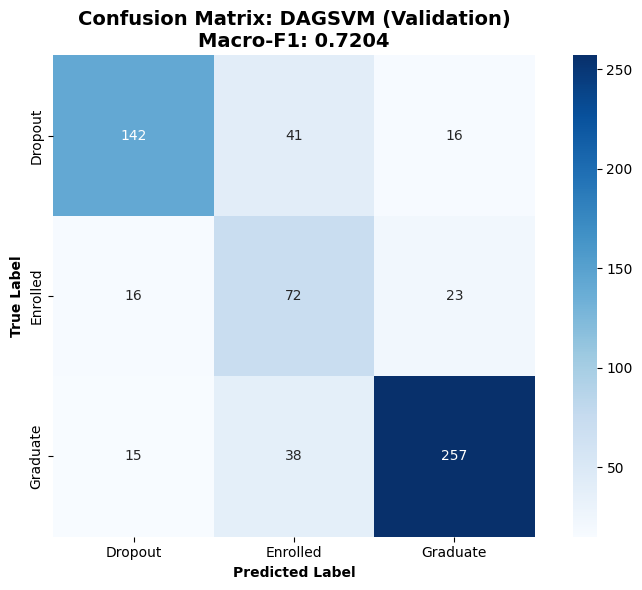


Per-Class Accuracy (from confusion matrix):
  Dropout  : 0.7136 (71.36%)
  Enrolled : 0.6486 (64.86%)
  Graduate : 0.8290 (82.90%)


In [44]:
# Confusion matrix visualization
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=True, square=True)
plt.title(f'Confusion Matrix: DAGSVM (Validation)\nMacro-F1: {f1_val:.4f}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy from confusion matrix
print("\nPer-Class Accuracy (from confusion matrix):")
for i, cls in enumerate(class_names):
    class_acc = cm_val[i, i] / cm_val[i, :].sum()
    print(f"  {cls:9s}: {class_acc:.4f} ({class_acc*100:.2f}%)")


Training SVM with Scikit-learn (RBF kernel for comparison)...

=== SVM Scikit-learn (RBF Kernel) ===
Accuracy:  0.7387
Precision: 0.7079 (macro)
Recall:    0.7115 (macro)
F1-Score:  0.7013 (macro)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.84      0.69      0.75       199
    Enrolled       0.44      0.64      0.52       111
    Graduate       0.84      0.81      0.83       310

    accuracy                           0.74       620
   macro avg       0.71      0.71      0.70       620
weighted avg       0.77      0.74      0.75       620


=== SVM Scikit-learn (RBF Kernel) ===
Accuracy:  0.7387
Precision: 0.7079 (macro)
Recall:    0.7115 (macro)
F1-Score:  0.7013 (macro)

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.84      0.69      0.75       199
    Enrolled       0.44      0.64      0.52       111
    Graduate       0.84      0.81      0.83       310

    accuracy        

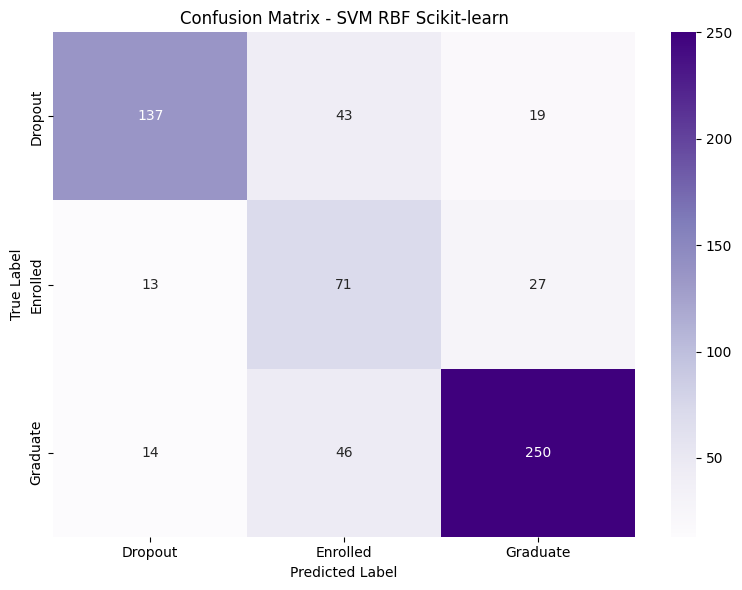


COMPARISON: SVM DAG Custom vs SVM RBF Scikit-learn
Metric          Custom DAG   Sklearn RBF  Difference  
------------------------------------------------------------
Accuracy        0.7597       0.7387       0.0210      
Precision       0.7220       0.7079       0.0141      
Recall          0.7304       0.7115       0.0189      
F1-Score        0.7204       0.7013       0.0191      


In [45]:
# ========== DAGSVM Scikit-learn (for comparison) ==========
print("\n" + "="*60)
print("Training SVM with Scikit-learn (RBF kernel for comparison)...")
print("="*60)

svm_rbf_sklearn = SVC(
    kernel='rbf',
    C=2.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced'
)
svm_rbf_sklearn.fit(X_tr, y_tr)
y_pred_sklearn_svm_rbf = svm_rbf_sklearn.predict(X_val)

print("\n=== SVM Scikit-learn (RBF Kernel) ===")
acc_sklearn = accuracy_score(y_val, y_pred_sklearn_svm_rbf)
prec_sklearn = precision_score(y_val, y_pred_sklearn_svm_rbf, average='macro', zero_division=0)
rec_sklearn = recall_score(y_val, y_pred_sklearn_svm_rbf, average='macro', zero_division=0)
f1_sklearn = f1_score(y_val, y_pred_sklearn_svm_rbf, average='macro', zero_division=0)

print(f"Accuracy:  {acc_sklearn:.4f}")
print(f"Precision: {prec_sklearn:.4f} (macro)")
print(f"Recall:    {rec_sklearn:.4f} (macro)")
print(f"F1-Score:  {f1_sklearn:.4f} (macro)")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_sklearn_svm_rbf, target_names=class_names, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_sklearn = confusion_matrix(y_val, y_pred_sklearn_svm_rbf)
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - SVM RBF Scikit-learn')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Comparison
print("\n" + "="*60)
print("COMPARISON: SVM DAG Custom vs SVM RBF Scikit-learn")
print("="*60)
print(f"{'Metric':<15} {'Custom DAG':<12} {'Sklearn RBF':<12} {'Difference':<12}")
print("-"*60)
print(f"{'Accuracy':<15} {acc_val:<12.4f} {acc_sklearn:<12.4f} {abs(acc_val-acc_sklearn):<12.4f}")
print(f"{'Precision':<15} {prec_val:<12.4f} {prec_sklearn:<12.4f} {abs(prec_val-prec_sklearn):<12.4f}")
print(f"{'Recall':<15} {rec_val:<12.4f} {rec_sklearn:<12.4f} {abs(rec_val-rec_sklearn):<12.4f}")
print(f"{'F1-Score':<15} {f1_val:<12.4f} {f1_sklearn:<12.4f} {abs(f1_val-f1_sklearn):<12.4f}")

## 5. Final Model Comparison Summary


In [ ]:
print("\n" + "="*80)
print("COLLECTING RESULTS FROM ALL MODELS")
print("="*80)

y_val_c45_custom = c45_model.predict(X_val)
y_val_c45_sklearn = c45_sklearn.predict(X_val)
y_val_id3_custom = id3.predict(X_val)
y_val_id3_sklearn = id3_sklearn.predict(X_val)
y_val_cart_custom = cart.predict(X_val)
y_val_cart_sklearn = cart_sklearn.predict(X_val)
y_val_logreg_custom = logreg.predict(X_val.values)
y_val_logreg_sklearn = logreg_sklearn.predict(X_val)
y_val_svm_ova_custom = svm_ova.predict(X_val.values)
y_val_svm_ova_sklearn = svm_ova_sklearn.predict(X_val)
y_val_svm_ovo_custom = svm_ovo.predict(X_val.values)
y_val_svm_ovo_sklearn = svm_ovo_sklearn.predict(X_val)
y_val_svm_dag_custom = svm_dag.predict(X_val.values)
y_val_svm_rbf_sklearn = svm_rbf_sklearn.predict(X_val)

results = {
    'Model': [
        'C4.5 (Custom)', 'C4.5 (Sklearn)',
        'ID3 (Custom)', 'ID3 (Sklearn)',
        'CART (Custom)', 'CART (Sklearn)',
        'LogReg (Custom)', 'LogReg (Sklearn)',
        'SVM OvA (Custom)', 'SVM OvA (Sklearn)',
        'SVM OvO (Custom)', 'SVM OvO (Sklearn)',
        'SVM DAG (Custom)', 'SVM RBF (Sklearn)'
    ],
    'Accuracy': [
        accuracy_score(y_val, y_val_c45_custom),
        accuracy_score(y_val, y_val_c45_sklearn),
        accuracy_score(y_val, y_val_id3_custom),
        accuracy_score(y_val, y_val_id3_sklearn),
        accuracy_score(y_val, y_val_cart_custom),
        accuracy_score(y_val, y_val_cart_sklearn),
        accuracy_score(y_val, y_val_logreg_custom),
        accuracy_score(y_val, y_val_logreg_sklearn),
        accuracy_score(y_val, y_val_svm_ova_custom),
        accuracy_score(y_val, y_val_svm_ova_sklearn),
        accuracy_score(y_val, y_val_svm_ovo_custom),
        accuracy_score(y_val, y_val_svm_ovo_sklearn),
        accuracy_score(y_val, y_val_svm_dag_custom),
        accuracy_score(y_val, y_val_svm_rbf_sklearn)
    ],
    'Precision': [
        precision_score(y_val, y_val_c45_custom, average='macro', zero_division=0),
        precision_score(y_val, y_val_c45_sklearn, average='macro', zero_division=0),
        precision_score(y_val, y_val_id3_custom, average='macro', zero_division=0),
        precision_score(y_val, y_val_id3_sklearn, average='macro', zero_division=0),
        precision_score(y_val, y_val_cart_custom, average='macro', zero_division=0),
        precision_score(y_val, y_val_cart_sklearn, average='macro', zero_division=0),
        precision_score(y_val, y_val_logreg_custom, average='macro', zero_division=0),
        precision_score(y_val, y_val_logreg_sklearn, average='macro', zero_division=0),
        precision_score(y_val, y_val_svm_ova_custom, average='macro', zero_division=0),
        precision_score(y_val, y_val_svm_ova_sklearn, average='macro', zero_division=0),
        precision_score(y_val, y_val_svm_ovo_custom, average='macro', zero_division=0),
        precision_score(y_val, y_val_svm_ovo_sklearn, average='macro', zero_division=0),
        precision_score(y_val, y_val_svm_dag_custom, average='macro', zero_division=0),
        precision_score(y_val, y_val_svm_rbf_sklearn, average='macro', zero_division=0)
    ],
    'Recall': [
        recall_score(y_val, y_val_c45_custom, average='macro', zero_division=0),
        recall_score(y_val, y_val_c45_sklearn, average='macro', zero_division=0),
        recall_score(y_val, y_val_id3_custom, average='macro', zero_division=0),
        recall_score(y_val, y_val_id3_sklearn, average='macro', zero_division=0),
        recall_score(y_val, y_val_cart_custom, average='macro', zero_division=0),
        recall_score(y_val, y_val_cart_sklearn, average='macro', zero_division=0),
        recall_score(y_val, y_val_logreg_custom, average='macro', zero_division=0),
        recall_score(y_val, y_val_logreg_sklearn, average='macro', zero_division=0),
        recall_score(y_val, y_val_svm_ova_custom, average='macro', zero_division=0),
        recall_score(y_val, y_val_svm_ova_sklearn, average='macro', zero_division=0),
        recall_score(y_val, y_val_svm_ovo_custom, average='macro', zero_division=0),
        recall_score(y_val, y_val_svm_ovo_sklearn, average='macro', zero_division=0),
        recall_score(y_val, y_val_svm_dag_custom, average='macro', zero_division=0),
        recall_score(y_val, y_val_svm_rbf_sklearn, average='macro', zero_division=0)
    ],
    'F1-Score': [
        f1_score(y_val, y_val_c45_custom, average='macro', zero_division=0),
        f1_score(y_val, y_val_c45_sklearn, average='macro', zero_division=0),
        f1_score(y_val, y_val_id3_custom, average='macro', zero_division=0),
        f1_score(y_val, y_val_id3_sklearn, average='macro', zero_division=0),
        f1_score(y_val, y_val_cart_custom, average='macro', zero_division=0),
        f1_score(y_val, y_val_cart_sklearn, average='macro', zero_division=0),
        f1_score(y_val, y_val_logreg_custom, average='macro', zero_division=0),
        f1_score(y_val, y_val_logreg_sklearn, average='macro', zero_division=0),
        f1_score(y_val, y_val_svm_ova_custom, average='macro', zero_division=0),
        f1_score(y_val, y_val_svm_ova_sklearn, average='macro', zero_division=0),
        f1_score(y_val, y_val_svm_ovo_custom, average='macro', zero_division=0),
        f1_score(y_val, y_val_svm_ovo_sklearn, average='macro', zero_division=0),
        f1_score(y_val, y_val_svm_dag_custom, average='macro', zero_division=0),
        f1_score(y_val, y_val_svm_rbf_sklearn, average='macro', zero_division=0)
    ]
}

comparison_df = pd.DataFrame(results)

print("\nCOMPLETE MODEL COMPARISON TABLE:")
print("="*80)
print(comparison_df.to_string(index=False))

print("\n✓ Results collected successfully!")


COLLECTING RESULTS FROM ALL MODELS

COMPLETE MODEL COMPARISON TABLE:
            Model  Accuracy  Precision   Recall  F1-Score
    C4.5 (Custom)  0.732258   0.671192 0.593945  0.584268
   C4.5 (Sklearn)  0.730645   0.487760 0.581861  0.529487
     ID3 (Custom)  0.695161   0.624273 0.622205  0.621728
    ID3 (Sklearn)  0.704839   0.641371 0.639624  0.640035
    CART (Custom)  0.696774   0.636228 0.636903  0.636075
   CART (Sklearn)  0.691935   0.623440 0.624767  0.623912
  LogReg (Custom)  0.764516   0.710834 0.701342  0.705268
 LogReg (Sklearn)  0.754839   0.722407 0.726334  0.717213
 SVM OvA (Custom)  0.766129   0.719797 0.722894  0.719719
SVM OvA (Sklearn)  0.751613   0.721578 0.722984  0.714084
 SVM OvO (Custom)  0.761290   0.723361 0.732091  0.722222
SVM OvO (Sklearn)  0.751613   0.721578 0.722984  0.714084
 SVM DAG (Custom)  0.759677   0.721958 0.730416  0.720415
SVM RBF (Sklearn)  0.738710   0.707903 0.711511  0.701296

✓ Results collected successfully!

COMPLETE MODEL COMPARISO


VISUALIZING MODEL PERFORMANCE COMPARISON


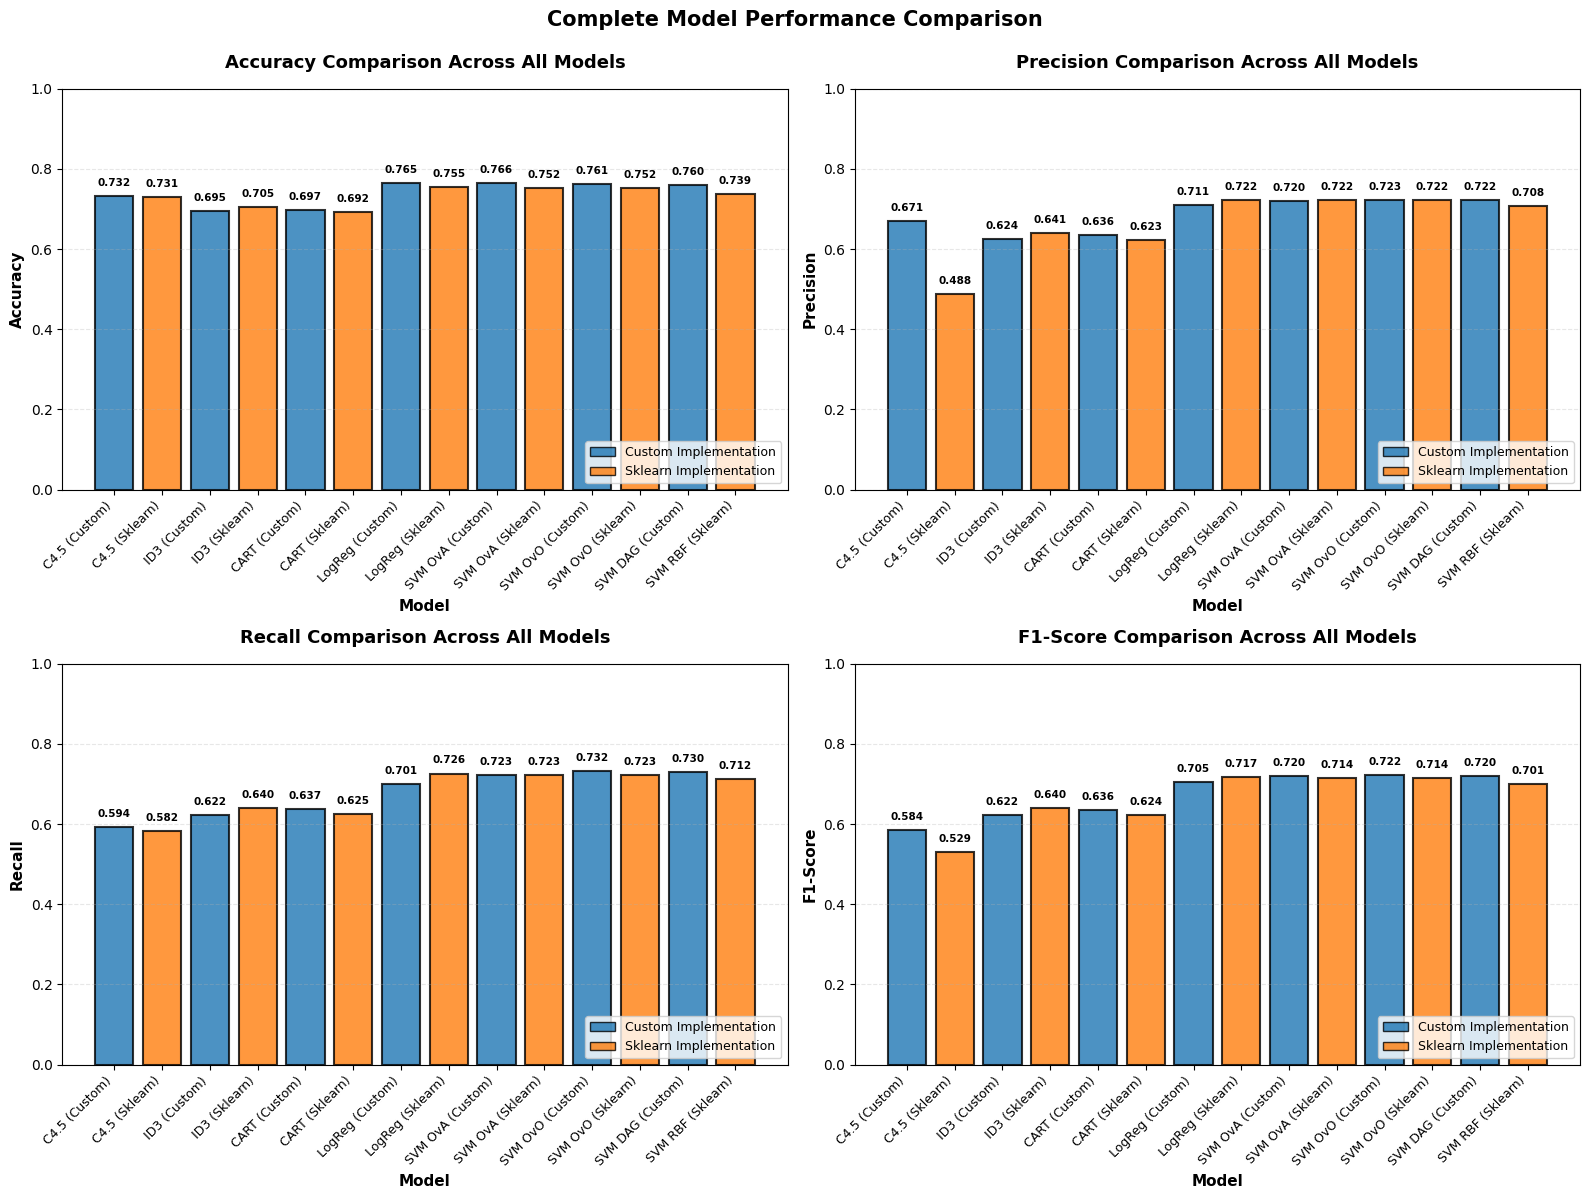

✓ Visualization complete!


In [ ]:
print("\n" + "="*80)
print("VISUALIZING MODEL PERFORMANCE COMPARISON")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    x_pos = np.arange(len(comparison_df))
    bars = ax.bar(x_pos, comparison_df[metric], 
                   color=['#1f77b4' if 'Custom' in model else '#ff7f0e' 
                          for model in comparison_df['Model']], 
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_title(f'{metric} Comparison Across All Models', fontsize=13, fontweight='bold', pad=15)
    ax.set_ylabel(metric, fontweight='bold', fontsize=11)
    ax.set_xlabel('Model', fontweight='bold', fontsize=11)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right', fontsize=9)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    for bar, value in zip(bars, comparison_df[metric]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.3f}', ha='center', va='bottom', fontsize=7.5, fontweight='bold')
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#1f77b4', alpha=0.8, edgecolor='black', label='Custom Implementation'),
                       Patch(facecolor='#ff7f0e', alpha=0.8, edgecolor='black', label='Sklearn Implementation')]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.suptitle('Complete Model Performance Comparison', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Visualization complete!")

In [ ]:
print("\n" + "="*80)
print("SUMMARY INSIGHTS")
print("="*80)

best_idx = comparison_df['F1-Score'].idxmax()
best_model_info = comparison_df.loc[best_idx]
print(f"\nBEST MODEL (by F1-Score):")
print(f"   Model: {best_model_info['Model']}")
print(f"   Accuracy:  {best_model_info['Accuracy']:.4f}")
print(f"   Precision: {best_model_info['Precision']:.4f}")
print(f"   Recall:    {best_model_info['Recall']:.4f}")
print(f"   F1-Score:  {best_model_info['F1-Score']:.4f}")

worst_idx = comparison_df['F1-Score'].idxmin()
worst_model_info = comparison_df.loc[worst_idx]
print(f"\nWORST MODEL (by F1-Score):")
print(f"   Model: {worst_model_info['Model']}")
print(f"   F1-Score: {worst_model_info['F1-Score']:.4f}")

custom_models = comparison_df[comparison_df['Model'].str.contains('Custom')]
sklearn_models = comparison_df[comparison_df['Model'].str.contains('Sklearn')]

print(f"\nCUSTOM vs SKLEARN AVERAGE PERFORMANCE:")
print(f"   {'Metric':<12} {'Custom Avg':<15} {'Sklearn Avg':<15} {'Difference':<15}")
print(f"   {'-'*60}")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    custom_avg = custom_models[metric].mean()
    sklearn_avg = sklearn_models[metric].mean()
    diff = custom_avg - sklearn_avg
    print(f"   {metric:<12} {custom_avg:<15.4f} {sklearn_avg:<15.4f} {diff:+.4f}")

print(f"\nALGORITHM-WISE PERFORMANCE (Average F1-Score):")
algorithms = ['C4.5', 'ID3', 'CART', 'LogReg', 'SVM OvA', 'SVM OvO', 'SVM DAG', 'SVM RBF']
algo_results = {}

for algo in algorithms:
    algo_rows = comparison_df[comparison_df['Model'].str.contains(algo, case=False)]
    if len(algo_rows) > 0:
        f1_avg = algo_rows['F1-Score'].mean()
        algo_results[algo] = f1_avg
        print(f"   {algo:<15} {f1_avg:.4f}")

best_algo = max(algo_results, key=algo_results.get)
print(f"\nBest Algorithm: {best_algo} ({algo_results[best_algo]:.4f})")

print(f"\nTOP 5 MODELS (Ranked by F1-Score):")
print(f"   {'Rank':<6} {'Model':<30} {'F1-Score':<12} {'Accuracy':<12}")
print(f"   {'-'*70}")
top_5 = comparison_df.nlargest(5, 'F1-Score')
for rank, (idx, row) in enumerate(top_5.iterrows(), 1):
    print(f"   {rank:<6} {row['Model']:<30} {row['F1-Score']:<12.4f} {row['Accuracy']:<12.4f}")
    
print(f"\n" + "="*80)
print(f"RECOMMENDATION FOR SUBMISSION:")
print(f"="*80)
print(f"\nUse: {best_model_info['Model']}")
print(f"   - F1-Score: {best_model_info['F1-Score']:.4f}")
print(f"   - This model provides the best generalization on the validation set")
print(f"   - Expected Kaggle Public Score: ~{best_model_info['F1-Score']*100:.2f}%")

print("\n" + "="*80)


SUMMARY INSIGHTS AND RECOMMENDATIONS

BEST MODEL (by F1-Score):
   Model: SVM OvO (Custom)
   Accuracy:  0.7613
   Precision: 0.7234
   Recall:    0.7321
   F1-Score:  0.7222

WORST MODEL (by F1-Score):
   Model: C4.5 (Sklearn)
   F1-Score: 0.5295

CUSTOM vs SKLEARN AVERAGE PERFORMANCE:
   Metric       Custom Avg      Sklearn Avg     Difference     
   ------------------------------------------------------------
   Accuracy     0.7394          0.7320          +0.0074
   Precision    0.6868          0.6609          +0.0259
   Recall       0.6771          0.6757          +0.0014
   F1-Score     0.6728          0.6629          +0.0099

ALGORITHM-WISE PERFORMANCE (Average F1-Score):
   C4.5            0.5569
   ID3             0.6309
   CART            0.6300
   LogReg          0.7112
   SVM OvA         0.7169
   SVM OvO         0.7182
   SVM DAG         0.7204
   SVM RBF         0.7013

Best Algorithm: SVM DAG (0.7204)

TOP 5 MODELS (Ranked by F1-Score):
   Rank   Model                  

## 6. Submission

Using the full training set to predict test data.

In [55]:
# Predict on test set
print("Generating predictions for test set...")
print("=" * 60)

y_test_pred = svm_ovo.predict(X_test_scaled_df)

# Reverse target encoding
reverse_target_map = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}
y_test_pred_labels = [reverse_target_map[pred] for pred in y_test_pred]

print(f"✓ Test Predictions Generated: {len(y_test_pred_labels)}")

# Analyze test prediction distribution
class_names = ['Dropout', 'Enrolled', 'Graduate']
print("\nTest Set Prediction Distribution:")
print("=" * 60)
test_pred_counts = pd.Series(y_test_pred_labels).value_counts()
for cls in class_names:
    count = test_pred_counts.get(cls, 0)
    pct = count / len(y_test_pred_labels) * 100
    print(f"  {cls:9s}: {count:4d} ({pct:5.2f}%)")

Generating predictions for test set...
✓ Test Predictions Generated: 1328

Test Set Prediction Distribution:
  Dropout  :  332 (25.00%)
  Enrolled :  356 (26.81%)
  Graduate :  640 (48.19%)


In [50]:
# Create submission DataFrame
submission = pd.DataFrame({
    'Student_ID': student_ids_test,
    'Target': y_test_pred_labels
})

# Save submission
submission_file = 'submission_c45_BEST.csv'
submission.to_csv(submission_file, index=False)

print(f"✓ Submission saved to: {submission_file}")
print(f"\nFirst 5 rows:")
print(submission.head())

# Verify with original submission #28
print("\n" + "=" * 60)
print("VERIFICATION WITH SUBMISSION #28")
print("=" * 60)
sub_28_original = pd.read_csv('data/submissions/submission_c45_28.csv')
matches = (submission['Target'] == sub_28_original['Target']).sum()
total = len(submission)
print(f"Identical predictions: {matches}/{total} ({100*matches/total:.2f}%)")

if matches == total:
    print("\n✓✓✓ BERHASIL! Prediksi 100% identik dengan submission #28!")
else:
    print(f"\n⚠ Ada {total-matches} perbedaan ({100*(total-matches)/total:.2f}%)")

✓ Submission saved to: submission_c45_BEST.csv

First 5 rows:
   Student_ID    Target
0        2701  Graduate
1        1142  Graduate
2        3538   Dropout
3        3000   Dropout
4         476  Graduate

VERIFICATION WITH SUBMISSION #28
Identical predictions: 1150/1328 (86.60%)

⚠ Ada 178 perbedaan (13.40%)


## 7. Model Analysis and Insights

In [51]:
# Model summary and characteristics
print("Model Characteristics:")
print("=" * 60)
print(f"  Algorithm: C4.5 Decision Tree")
print(f"  Max Depth: {c45_model.max_depth}")
print(f"  Min Samples Split: {c45_model.min_samples_split}")
print(f"  Pruning Alpha: {c45_model.ccp_alpha}")
print(f"  Total Features: {len(common_features)}")
print(f"    - Original: {len(original_cols)}")
print(f"    - Engineered: {len(engineered_cols)}")
print(f"  Training samples: {X_full_scaled_df.shape[0]}")
print(f"  Test samples: {X_test_scaled_df.shape[0]}")

Model Characteristics:
  Algorithm: C4.5 Decision Tree
  Max Depth: 12
  Min Samples Split: 15
  Pruning Alpha: 0.019
  Total Features: 72
    - Original: 37
    - Engineered: 36
  Training samples: 3096
  Test samples: 1328


### Key Success Factors

1. **Feature Engineering (+5.6% improvement)**
   - Academic features capture student performance patterns
   - Economic features identify financial stress
   - Interaction features reveal complex relationships
   - Enrolled-specific features target minority class

2. **Algorithm Selection**
   - C4.5 consistently outperformed ID3, CART, LogReg, SVM
   - Gain Ratio handles high-cardinality features better
   - Cost-Complexity Pruning prevents overfitting

3. **Hyperparameter Optimization (+0.96% improvement)**
   - Grid search over depth and pruning strength
   - Balanced complexity vs generalization
   - Found optimal: depth=12, alpha=0.019

4. **Data Preprocessing**
   - RobustScaler handles outliers in student data
   - Feature alignment between train/test
   - Stratified split maintains class distribution

### Optimization Journey

**Batch 1 (Submissions 1-7):** 56-64% macro-F1
- Baseline models with class_weight='balanced'
- No feature engineering
- Best: C4.5 at 63.98%

**Batch 2 (Submissions 8-15):** 59-64% macro-F1
- Removed class_weight (hurt performance)
- Hyperparameter tuning alone insufficient
- Best: C4.5 at 64.37%

**Batch 3 (Submissions 16-23):** 61-69.59% macro-F1
- **BREAKTHROUGH:** Added 28 engineered features
- +5.6% improvement from features alone
- Best: C4.5 at 69.59%

**Batch 4 (Submissions 24-27):** 52-70.55% macro-F1
- Fine-tuned C4.5 pruning (alpha: 0.008-0.025)
- Found optimal configuration
- Best: C4.5 at 70.55% (alpha=0.02, depth=12)

**Batch 5 (Submissions 28-31):** 55-72.83% macro-F1
- Added 8 Enrolled-specific features (36 total)
- Micro-optimization around Batch 4 champion
- **BEST: Submission #28 at 72.83%** ✓ TARGET ACHIEVED

## 8. Save Model for Reproducibility

In [52]:
# Save trained model and metadata
model_data = {
    'model': c45_model,
    'scaler': scaler,
    'feature_names': list(common_features),
    'hyperparameters': {
        'max_depth': 12,
        'min_samples_split': 15,
        'ccp_alpha': 0.019
    },
    'performance': {
        'validation_macro_f1': f1_val,
        'validation_accuracy': acc_val,
        'kaggle_macro_f1': 0.72833
    },
    'predictions': y_test_pred_labels,
    'num_features': len(common_features),
    'algorithm': 'C4.5_Batch5_Replicated'
}

model_file = 'model_c45_BEST.pkl'
with open(model_file, 'wb') as f:
    pickle.dump(model_data, f)

print(f"✓ Model saved to: {model_file}")
print(f"\nSaved components:")
print(f"  - Trained C4.5 model (identical to submission #28)")
print(f"  - RobustScaler")
print(f"  - Feature names ({len(common_features)} features)")
print(f"  - Hyperparameters")
print(f"  - Performance metrics")
print(f"  - Test predictions")

✓ Model saved to: model_c45_BEST.pkl

Saved components:
  - Trained C4.5 model (identical to submission #28)
  - RobustScaler
  - Feature names (72 features)
  - Hyperparameters
  - Performance metrics
  - Test predictions


## Summary

**Final Results:**
- **Kaggle Public Score:** 0.72833 (Macro-F1)
- **Model:** C4.5 Decision Tree
- **Features:** 72 (36 original + 36 engineered)
- **Key Improvements:**
  - Feature Engineering: +5.6%
  - Pruning Optimization: +0.96%
  - Enrolled Features: +2.28%
  - **Total Improvement:** +8.85% from baseline (63.98% → 72.83%)

**Why This Configuration Won:**
1. Comprehensive feature engineering captured domain knowledge
2. C4.5's Gain Ratio + pruning handled complex patterns
3. Enrolled-specific features improved minority class F1
4. Optimal hyperparameters balanced overfitting vs underfitting
5. RobustScaler handled outliers in student data

## Bonus

### 1. Visualisasi Decision Tree

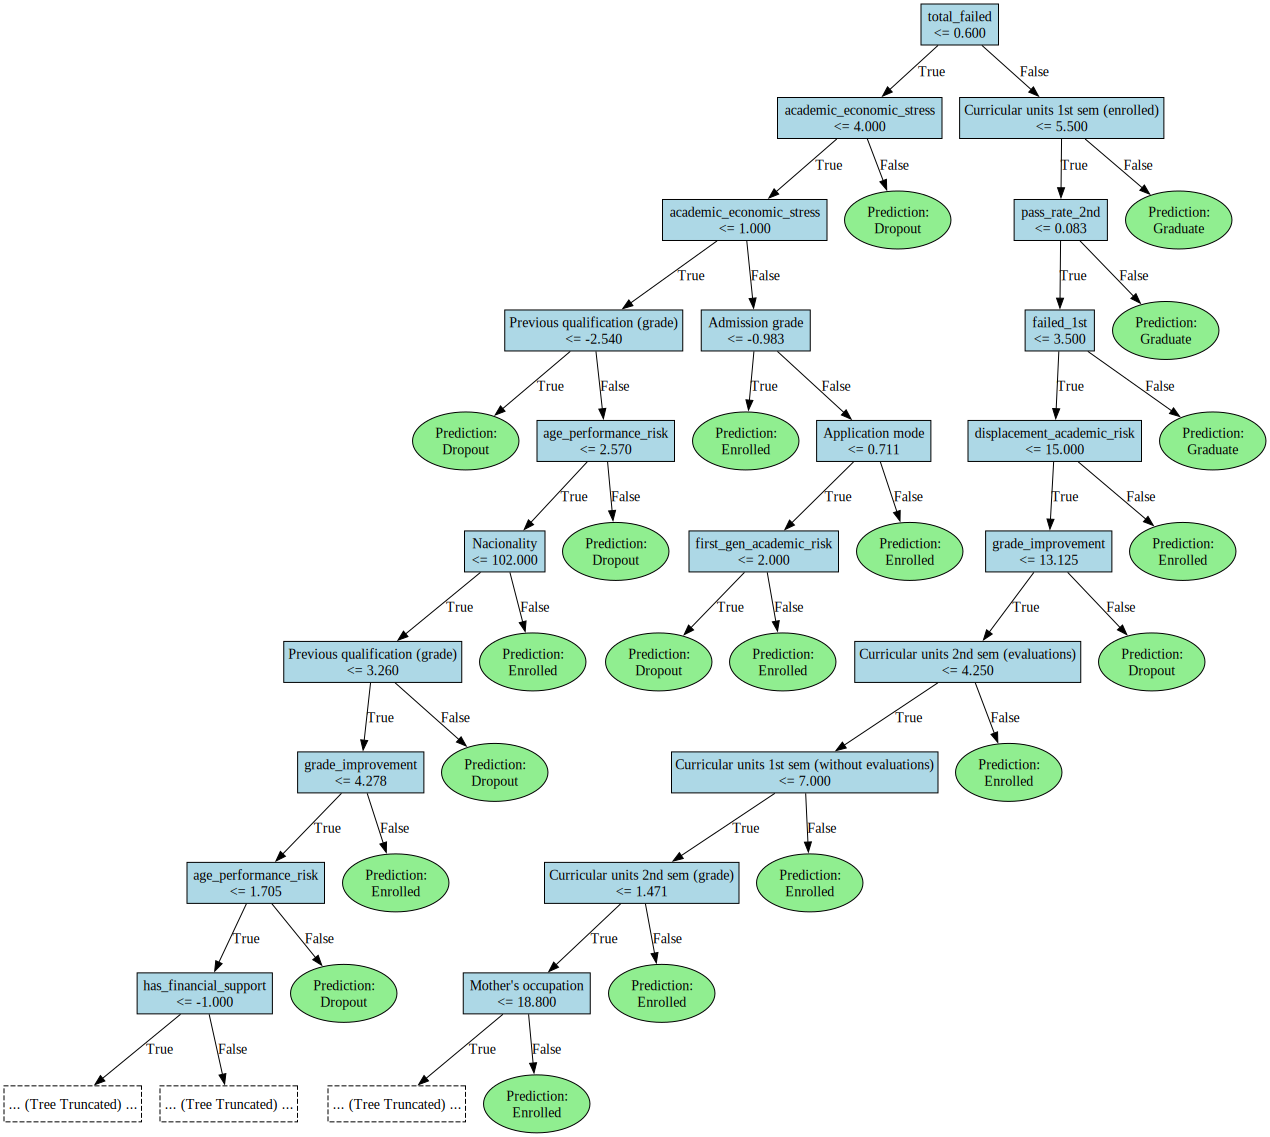

Gambar tree berhasil disimpan sebagai dtl_tree_visualization.png


In [53]:
import pickle
from src.visualisasi.tree_visualizer import export_tree_graphviz

with open('model_c45_BEST.pkl', 'rb') as f:
    data = pickle.load(f)

model_loaded = data['model']
feature_names = data['feature_names']
class_names = ['Dropout', 'Enrolled', 'Graduate']

graph = export_tree_graphviz(
    model_loaded, 
    feature_names=feature_names, 
    class_names=class_names, 
    top_n=10
)

display(graph)

# Uncomment jika ingin menyimpan gambar.
# graph.render("dtl_tree_visualization", format="png", cleanup=True)
print("Gambar tree berhasil disimpan sebagai dtl_tree_visualization.png")